In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from gadds import AreaDetectorImage

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
mpl.rcParams['mathtext.default'] = 'regular'


In [2]:
gfrm_files = [
    r"test\20250709_S_MeO_B01_000.gfrm",
    r"test\20250709_S_MeO_B01_001.gfrm"
]


In [3]:
area_detectors = [AreaDetectorImage(gfrm_file) for gfrm_file in gfrm_files]

for area_detector in area_detectors:
    # Display header information
    print("=== GFRM File Header Information ===")
    if hasattr(area_detector.image, 'header'):
        print(f"TITLE: {area_detector.image.header['TITLE'].strip()}")
    else:
        print("No header information available")

    print("=== Processed Parameters ===")
    print(f"Alpha (2θ center): {np.rad2deg(area_detector.alpha):.2f}°")
    print(f"Distance: {area_detector.distance:.2f} cm")
    print(f"Detector center (x, y): {area_detector.centerXY}")
    print(f"Pixel density (x, y): {area_detector.densityXY} pixels/cm")
    print(f"Scale factor: {area_detector.scale}")
    print(f"Offset: {area_detector.offset}")
    print("=== end ===\n")
    print("Converting to 2θ-γ space...")
    area_detector.convert(n_twoth=512, n_gamma=512)
    print(f"Converted image shape: {area_detector.data_converted.shape}\n")

  File "c:\Users\danielliu\Documents\git-local\gaddsconverter\gadds.py", line 86, in rowcol_to_angles
    nX, nY = self.image.dim1, self.image.dim2
  File "c:\Users\danielliu\Documents\git-local\gaddsconverter\gadds.py", line 86, in rowcol_to_angles
    nX, nY = self.image.dim1, self.image.dim2
  File "c:\Users\danielliu\Documents\git-local\gaddsconverter\gadds.py", line 86, in rowcol_to_angles
    nX, nY = self.image.dim1, self.image.dim2


=== GFRM File Header Information ===
TITLE: 20250709_S_MeO
20250709_S_MeO
=== Processed Parameters ===
Alpha (2θ center): 20.00°
Distance: 22.45 cm
Detector center (x, y): (1003.7000122, 1022.0999756)
Pixel density (x, y): (147.0628052, 147.0628052) pixels/cm
Scale factor: 1.0
Offset: 0.0
=== end ===

Converting to 2θ-γ space...
Converted image shape: (512, 512)

=== GFRM File Header Information ===
TITLE: 20250709_S_MeO
20250709_S_MeO
=== Processed Parameters ===
Alpha (2θ center): 30.00°
Distance: 22.45 cm
Detector center (x, y): (1003.7000122, 1022.0999756)
Pixel density (x, y): (147.0628052, 147.0628052) pixels/cm
Scale factor: 1.0
Offset: 0.0
=== end ===

Converting to 2θ-γ space...
Converted image shape: (512, 512)

=== GFRM File Header Information ===
TITLE: 20250709_S_MeO
20250709_S_MeO
=== Processed Parameters ===
Alpha (2θ center): 30.00°
Distance: 22.45 cm
Detector center (x, y): (1003.7000122, 1022.0999756)
Pixel density (x, y): (147.0628052, 147.0628052) pixels/cm
Scale fa

# GADDS Area Detector Merging with Weight Normalization

This notebook demonstrates merging of two area detectors with different weight normalization approaches for handling overlapping regions.

## Overview

We implement and compare two methods for handling detector overlap regions:

### Method 1: Original Data-Driven Approach
- **Boundary Detection**: Uses interpolated detector data coverage to determine boundaries
- **Weight Assignment**: Weight = 1 for single detector coverage, Weight = 2 for actual overlap
- **Characteristics**: Creates irregular but accurate boundaries based on actual data coverage

### Method 2: Convex Hull Approach  
- **Boundary Detection**: Creates a convex hull around the original overlap region
- **Weight Assignment**: Weight = 1 outside hull, Weight = 2 for all points inside hull
- **Characteristics**: Creates a smooth, geometric boundary that expands the overlap region

## Key Features
- **Common Grid**: Unified coordinate system covering both detectors
- **Proper Normalization**: `Final Data = Raw Data ÷ Weight Grid`
- **Curved Boundaries**: Both methods respect detector geometry
- **Visual Comparison**: Side-by-side analysis of both approaches

In [4]:
# ============================================================================
# METHOD 1: ORIGINAL DATA-DRIVEN WEIGHT GRID
# ============================================================================
print("=== Method 1: Original Data-Driven Weight Grid ===")

# Get coordinate ranges for each detector
detector_ranges = []
for i, area_detector in enumerate(area_detectors):
    twoth_min, twoth_max = area_detector.indexes[1].min(), area_detector.indexes[1].max()
    gamma_min, gamma_max = area_detector.indexes[0].min(), area_detector.indexes[0].max()
    detector_ranges.append((twoth_min, twoth_max, gamma_min, gamma_max))
    print(f"Detector {i}: 2θ = [{twoth_min:.2f}, {twoth_max:.2f}]°, γ = [{gamma_min:.2f}, {gamma_max:.2f}]°")

# Create common grid covering both detectors
all_twoth_min = min(detector_ranges[0][0], detector_ranges[1][0])
all_twoth_max = max(detector_ranges[0][1], detector_ranges[1][1])
all_gamma_min = min(detector_ranges[0][2], detector_ranges[1][2])
all_gamma_max = max(detector_ranges[0][3], detector_ranges[1][3])

# Use finest resolution from both detectors
twoth_step = min(
    area_detectors[0].indexes[1][1] - area_detectors[0].indexes[1][0],
    area_detectors[1].indexes[1][1] - area_detectors[1].indexes[1][0]
)
gamma_step = min(
    area_detectors[0].indexes[0][1] - area_detectors[0].indexes[0][0],
    area_detectors[1].indexes[0][1] - area_detectors[1].indexes[0][0]
)

n_twoth = int((all_twoth_max - all_twoth_min) / twoth_step) + 1
n_gamma = int((all_gamma_max - all_gamma_min) / gamma_step) + 1

common_twoth = np.linspace(all_twoth_min, all_twoth_max, n_twoth)
common_gamma = np.linspace(all_gamma_min, all_gamma_max, n_gamma)

print(f"Common grid: {n_gamma} × {n_twoth} points, resolution: {twoth_step:.4f}° × {gamma_step:.4f}°")

# Initialize arrays
merged_data = np.zeros((n_gamma, n_twoth))
weight_grid = np.zeros((n_gamma, n_twoth))
twoth_mesh, gamma_mesh = np.meshgrid(common_twoth, common_gamma, indexing='xy')

# Process each detector with accurate boundary detection
from scipy.interpolate import RegularGridInterpolator

detector_coverage_masks = []

for i, area_detector in enumerate(area_detectors):
    print(f"Processing detector {i}...")
    
    # Create data interpolator
    interpolator = RegularGridInterpolator(
        (area_detector.indexes[0], area_detector.indexes[1]),
        area_detector.data_converted,
        bounds_error=False, fill_value=0
    )
    interpolated_data = interpolator((gamma_mesh, twoth_mesh))
    
    # Create coverage interpolator for accurate boundaries
    detector_mask = area_detector.data_converted > 0
    coverage_interpolator = RegularGridInterpolator(
        (area_detector.indexes[0], area_detector.indexes[1]),
        detector_mask.astype(float),
        bounds_error=False, fill_value=0, method='linear'
    )
    coverage_values = coverage_interpolator((gamma_mesh, twoth_mesh))
    
    # Determine detector coverage with boundary constraints
    within_bounds = ((np.deg2rad(gamma_mesh) >= area_detector.limits[2]) & 
                     (np.deg2rad(gamma_mesh) <= area_detector.limits[3]) &
                     (np.deg2rad(twoth_mesh) >= area_detector.limits[0]) & 
                     (np.deg2rad(twoth_mesh) <= area_detector.limits[1]))
    
    data_coverage_mask = interpolated_data > 0
    coverage_mask = (coverage_values > 0.1) & within_bounds
    final_coverage_mask = data_coverage_mask | (coverage_mask & (interpolated_data >= 0))
    
    detector_coverage_masks.append(final_coverage_mask)
    
    # Accumulate data and weights
    merged_data[final_coverage_mask] += interpolated_data[final_coverage_mask]
    weight_grid[final_coverage_mask] += 1

# Find overlap region
overlap_mask = detector_coverage_masks[0] & detector_coverage_masks[1]

print(f"Coverage analysis:")
for i, mask in enumerate(detector_coverage_masks):
    print(f"  Detector {i}: {np.sum(mask):,} pixels")
print(f"  Overlap region: {np.sum(overlap_mask):,} pixels")

# Apply normalization
normalized_data = np.divide(merged_data, weight_grid, out=np.zeros_like(merged_data), where=weight_grid!=0)

print(f"✓ Method 1 completed: {np.sum(weight_grid > 1):,} overlap pixels, max weight = {np.max(weight_grid)}")

=== Method 1: Original Data-Driven Weight Grid ===
Detector 0: 2θ = [2.46, 39.97]°, γ = [-171.75, -8.29]°
Detector 1: 2θ = [12.46, 49.09]°, γ = [-143.93, -36.20]°
Common grid: 776 × 651 points, resolution: 0.0717° × 0.2108°
Processing detector 0...
Processing detector 1...
Coverage analysis:
  Detector 0: 180,257 pixels
  Detector 1: 113,314 pixels
  Overlap region: 80,653 pixels
✓ Method 1 completed: 80,653 overlap pixels, max weight = 2.0


In [5]:
# ============================================================================
# METHOD 2: CONVEX HULL WEIGHT GRID
# ============================================================================
print("=== Method 2: Convex Hull Weight Grid ===")

from scipy.spatial import ConvexHull
from matplotlib.path import Path

# Find all points where original weight_grid == 2 (actual overlap region)
overlap_points_indices = np.where(weight_grid == 2)
overlap_gamma_indices = overlap_points_indices[0]  # Row indices (γ)
overlap_twoth_indices = overlap_points_indices[1]  # Column indices (2θ)

# Convert indices to actual coordinates
overlap_gamma_coords = common_gamma[overlap_gamma_indices]
overlap_twoth_coords = common_twoth[overlap_twoth_indices]

print(f"Original overlap region: {len(overlap_gamma_coords):,} points")
print(f"  2θ range: [{np.min(overlap_twoth_coords):.2f}, {np.max(overlap_twoth_coords):.2f}]°")
print(f"  γ range: [{np.min(overlap_gamma_coords):.2f}, {np.max(overlap_gamma_coords):.2f}]°")

if len(overlap_gamma_coords) > 3:  # Need at least 3 points for hull
    
    # Create convex hull around overlap points
    overlap_points_2d = np.column_stack((overlap_twoth_coords, overlap_gamma_coords))
    
    try:
        hull = ConvexHull(overlap_points_2d)
        hull_points = overlap_points_2d[hull.vertices]
        hull_points_closed = np.vstack([hull_points, hull_points[0]])  # Close for plotting
        
        print(f"Convex hull created with {len(hull_points)} vertices")
        
        # Create new weight grid with weight = 2 inside convex hull
        hull_path = Path(hull_points)
        convex_hull_weight_grid = weight_grid.copy()
        
        # Test all grid points for inclusion in hull
        mesh_points = np.column_stack((twoth_mesh.ravel(), gamma_mesh.ravel()))
        inside_hull = hull_path.contains_points(mesh_points)
        inside_hull_2d = inside_hull.reshape(twoth_mesh.shape)
        
        # Set weight = 2 for points inside hull that have detector coverage
        points_with_coverage = convex_hull_weight_grid > 0
        points_in_hull = inside_hull_2d & points_with_coverage
        convex_hull_weight_grid[points_in_hull] = 2
        
        # Apply normalization with new weights
        convex_hull_normalized_data = np.divide(merged_data, convex_hull_weight_grid, 
                                              out=np.zeros_like(merged_data), 
                                              where=convex_hull_weight_grid!=0)
        
        # Calculate statistics
        points_with_weight_two = np.sum(convex_hull_weight_grid == 2)
        points_with_weight_one = np.sum(convex_hull_weight_grid == 1)
        total_points_in_hull = np.sum(points_in_hull)
        
        # Calculate hull area
        hull_area = 0.5 * np.abs(np.dot(hull_points_closed[:-1, 0], hull_points_closed[1:, 1]) - 
                                np.dot(hull_points_closed[1:, 0], hull_points_closed[:-1, 1]))
        
        print(f"Hull statistics:")
        print(f"  Area: {hull_area:.2f} deg²")
        print(f"  Points with weight = 2: {points_with_weight_two:,}")
        print(f"  Points with weight = 1: {points_with_weight_one:,}")
        print(f"  Total points in hull: {total_points_in_hull:,}")
        
        # Calculate expansion
        original_overlap_points = np.sum(weight_grid == 2)
        additional_points = points_with_weight_two - original_overlap_points
        expansion_pct = 100 * additional_points / original_overlap_points if original_overlap_points > 0 else 0
        print(f"  Hull expansion: {additional_points:,} points ({expansion_pct:.1f}% increase)")
        
        hull_success = True
        
    except Exception as e:
        print(f"Error creating convex hull: {e}")
        hull_points_closed = None
        convex_hull_weight_grid = weight_grid.copy()
        convex_hull_normalized_data = normalized_data.copy()
        hull_success = False

else:
    print("Insufficient overlap points for convex hull")
    hull_points_closed = None
    convex_hull_weight_grid = weight_grid.copy()
    convex_hull_normalized_data = normalized_data.copy()
    hull_success = False

print(f"✓ Method 2 completed: Hull expansion method {'successful' if hull_success else 'failed'}")

=== Method 2: Convex Hull Weight Grid ===
Original overlap region: 80,653 points
  2θ range: [13.08, 36.11]°
  γ range: [-124.92, -54.90]°
Convex hull created with 63 vertices
Hull statistics:
  Area: 1295.69 deg²
  Points with weight = 2: 85,624
  Points with weight = 1: 127,294
  Total points in hull: 85,615
  Hull expansion: 4,971 points (6.2% increase)
✓ Method 2 completed: Hull expansion method successful
Hull statistics:
  Area: 1295.69 deg²
  Points with weight = 2: 85,624
  Points with weight = 1: 127,294
  Total points in hull: 85,615
  Hull expansion: 4,971 points (6.2% increase)
✓ Method 2 completed: Hull expansion method successful


=== Creating Side-by-Side Comparison ===


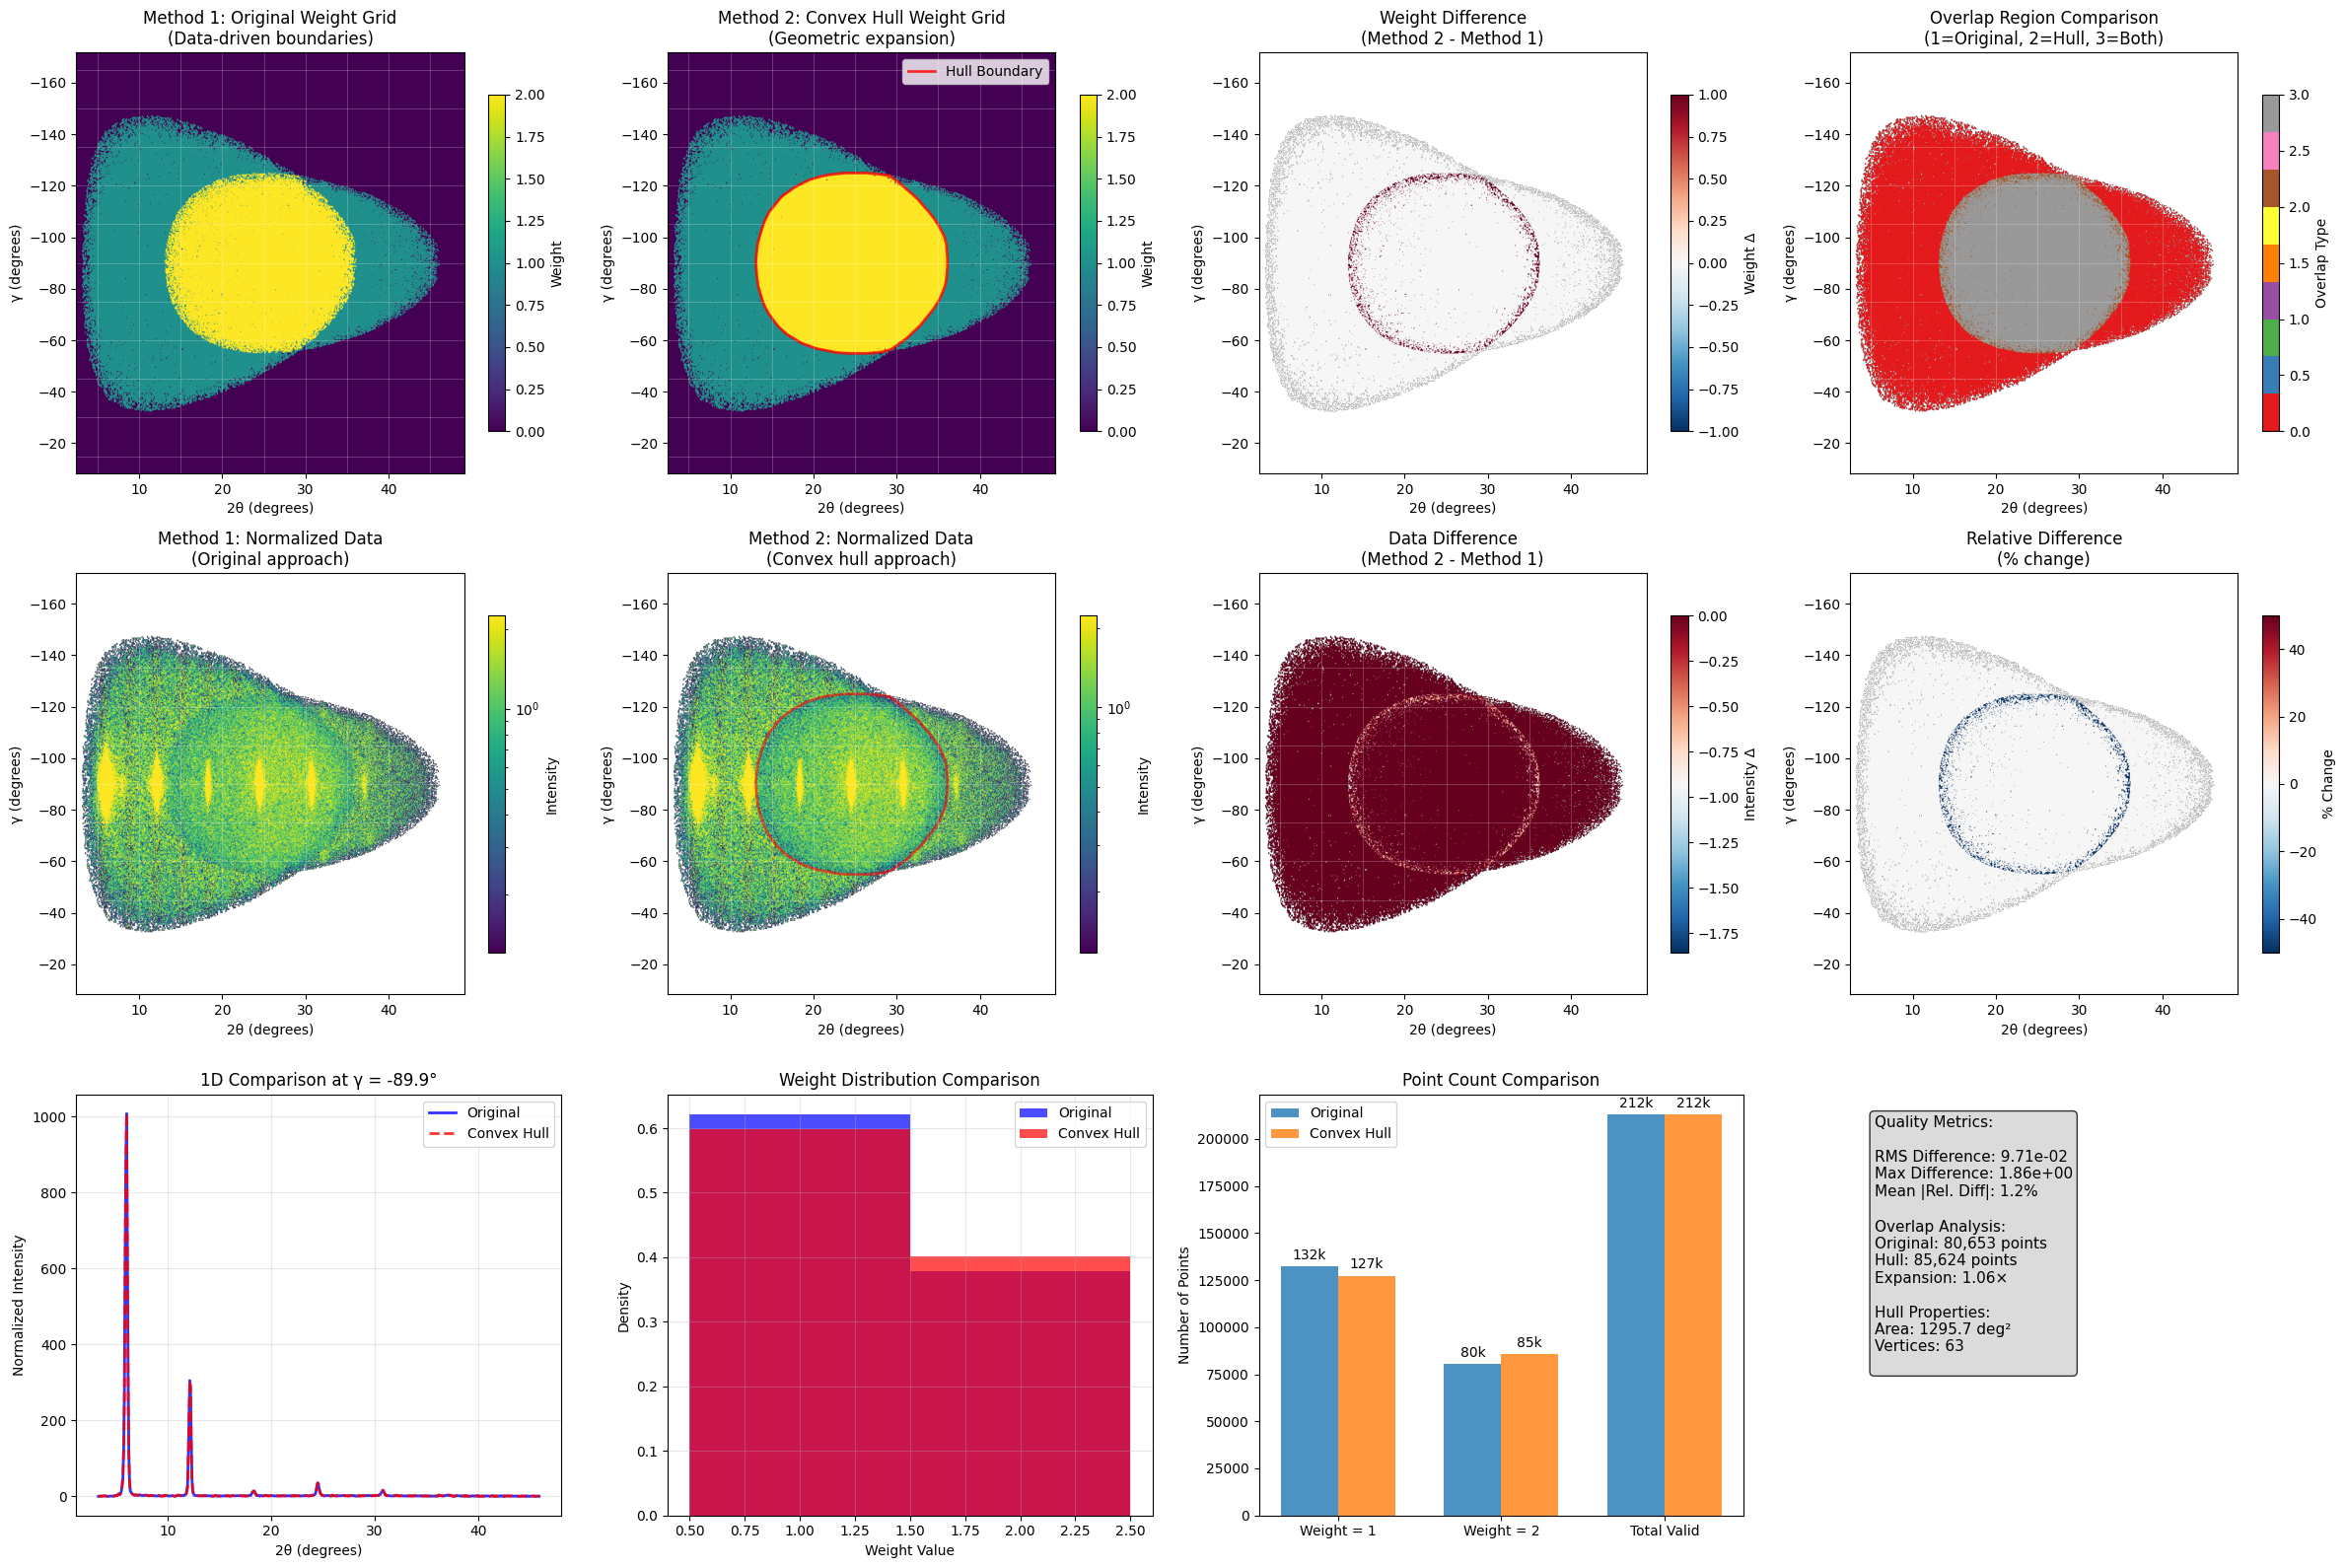

✓ Side-by-side comparison completed!


In [6]:
# ============================================================================
# SIDE-BY-SIDE COMPARISON: ORIGINAL vs CONVEX HULL METHODS
# ============================================================================
print("=== Creating Side-by-Side Comparison ===")

fig = plt.figure(figsize=(24, 16))

# Calculate display extent
extent = [common_twoth.min(), common_twoth.max(), common_gamma.max(), common_gamma.min()]

# ================================
# ROW 1: WEIGHT GRIDS
# ================================

# Original weight grid
ax1 = plt.subplot(3, 4, 1)
im1 = ax1.imshow(weight_grid, cmap='viridis', origin='upper', extent=extent, aspect='auto')
ax1.set_title('Method 1: Original Weight Grid\n(Data-driven boundaries)', fontsize=12)
ax1.set_xlabel('2θ (degrees)')
ax1.set_ylabel('γ (degrees)')
plt.colorbar(im1, ax=ax1, label='Weight', shrink=0.8)

# Convex hull weight grid
ax2 = plt.subplot(3, 4, 2)
im2 = ax2.imshow(convex_hull_weight_grid, cmap='viridis', origin='upper', extent=extent, aspect='auto')
ax2.set_title('Method 2: Convex Hull Weight Grid\n(Geometric expansion)', fontsize=12)
ax2.set_xlabel('2θ (degrees)')
ax2.set_ylabel('γ (degrees)')
if hull_success and hull_points_closed is not None:
    ax2.plot(hull_points_closed[:, 0], hull_points_closed[:, 1], 'r-', 
             linewidth=2, alpha=0.8, label='Hull Boundary')
    ax2.legend(fontsize=10)
plt.colorbar(im2, ax=ax2, label='Weight', shrink=0.8)

# Weight difference
ax3 = plt.subplot(3, 4, 3)
weight_diff = convex_hull_weight_grid - weight_grid
weight_diff[weight_grid == 0] = np.nan
im3 = ax3.imshow(weight_diff, cmap='RdBu_r', origin='upper', extent=extent, aspect='auto', 
                 vmin=-1, vmax=1)
ax3.set_title('Weight Difference\n(Method 2 - Method 1)', fontsize=12)
ax3.set_xlabel('2θ (degrees)')
ax3.set_ylabel('γ (degrees)')
plt.colorbar(im3, ax=ax3, label='Weight Δ', shrink=0.8)

# Overlap regions overlay
ax4 = plt.subplot(3, 4, 4)
overlap_comparison = np.zeros_like(weight_grid)
overlap_comparison[weight_grid == 2] = 1  # Original overlap
overlap_comparison[convex_hull_weight_grid == 2] += 2  # Hull overlap
overlap_comparison[weight_grid == 0] = np.nan
im4 = ax4.imshow(overlap_comparison, cmap='Set1', origin='upper', extent=extent, aspect='auto')
ax4.set_title('Overlap Region Comparison\n(1=Original, 2=Hull, 3=Both)', fontsize=12)
ax4.set_xlabel('2θ (degrees)')
ax4.set_ylabel('γ (degrees)')
plt.colorbar(im4, ax=ax4, label='Overlap Type', shrink=0.8)

# ================================
# ROW 2: NORMALIZED DATA
# ================================

# Original normalized data
ax5 = plt.subplot(3, 4, 5)
normalized_display = normalized_data.copy()
normalized_display[weight_grid == 0] = np.nan

if np.nansum(normalized_display) > 0:
    valid_data = normalized_display[normalized_display > 0]
    if len(valid_data) > 0:
        vmin = np.percentile(valid_data, 5)
        vmax = np.percentile(valid_data, 95)
        if vmin > 0 and vmax > vmin:
            im5 = ax5.imshow(normalized_display, cmap='viridis',
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                            origin='upper', extent=extent, aspect='auto')
        else:
            im5 = ax5.imshow(normalized_display, cmap='viridis',
                            origin='upper', extent=extent, aspect='auto')
    else:
        im5 = ax5.imshow(normalized_display, cmap='viridis',
                        origin='upper', extent=extent, aspect='auto')
else:
    im5 = ax5.imshow(normalized_display, cmap='viridis',
                    origin='upper', extent=extent, aspect='auto')

ax5.set_title('Method 1: Normalized Data\n(Original approach)', fontsize=12)
ax5.set_xlabel('2θ (degrees)')
ax5.set_ylabel('γ (degrees)')
plt.colorbar(im5, ax=ax5, label='Intensity', shrink=0.8)

# Convex hull normalized data
ax6 = plt.subplot(3, 4, 6)
hull_normalized_display = convex_hull_normalized_data.copy()
hull_normalized_display[convex_hull_weight_grid == 0] = np.nan

if np.nansum(hull_normalized_display) > 0:
    valid_hull_data = hull_normalized_display[hull_normalized_display > 0]
    if len(valid_hull_data) > 0:
        vmin_hull = np.percentile(valid_hull_data, 5)
        vmax_hull = np.percentile(valid_hull_data, 95)
        if vmin_hull > 0 and vmax_hull > vmin_hull:
            im6 = ax6.imshow(hull_normalized_display, cmap='viridis',
                            norm=colors.LogNorm(vmin=vmin_hull, vmax=vmax_hull),
                            origin='upper', extent=extent, aspect='auto')
        else:
            im6 = ax6.imshow(hull_normalized_display, cmap='viridis',
                            origin='upper', extent=extent, aspect='auto')
    else:
        im6 = ax6.imshow(hull_normalized_display, cmap='viridis',
                        origin='upper', extent=extent, aspect='auto')
else:
    im6 = ax6.imshow(hull_normalized_display, cmap='viridis',
                    origin='upper', extent=extent, aspect='auto')

ax6.set_title('Method 2: Normalized Data\n(Convex hull approach)', fontsize=12)
ax6.set_xlabel('2θ (degrees)')
ax6.set_ylabel('γ (degrees)')
if hull_success and hull_points_closed is not None:
    ax6.plot(hull_points_closed[:, 0], hull_points_closed[:, 1], 'r-', 
             linewidth=2, alpha=0.6)
plt.colorbar(im6, ax=ax6, label='Intensity', shrink=0.8)

# Data difference
ax7 = plt.subplot(3, 4, 7)
data_difference = convex_hull_normalized_data - normalized_data
data_difference[weight_grid == 0] = np.nan
im7 = ax7.imshow(data_difference, cmap='RdBu_r', origin='upper', extent=extent, aspect='auto')
ax7.set_title('Data Difference\n(Method 2 - Method 1)', fontsize=12)
ax7.set_xlabel('2θ (degrees)')
ax7.set_ylabel('γ (degrees)')
plt.colorbar(im7, ax=ax7, label='Intensity Δ', shrink=0.8)

# Relative difference (%)
ax8 = plt.subplot(3, 4, 8)
relative_diff = np.divide(data_difference, normalized_data, 
                         out=np.zeros_like(data_difference), 
                         where=normalized_data!=0) * 100
relative_diff[weight_grid == 0] = np.nan
im8 = ax8.imshow(relative_diff, cmap='RdBu_r', origin='upper', extent=extent, aspect='auto',
                 vmin=-50, vmax=50)
ax8.set_title('Relative Difference\n(% change)', fontsize=12)
ax8.set_xlabel('2θ (degrees)')
ax8.set_ylabel('γ (degrees)')
plt.colorbar(im8, ax=ax8, label='% Change', shrink=0.8)

# ================================
# ROW 3: ANALYSIS PLOTS
# ================================

# 1D comparison along 2θ (constant γ)
ax9 = plt.subplot(3, 4, 9)
gamma_center_idx = len(common_gamma) // 2
slice_original = normalized_data[gamma_center_idx, :]
slice_hull = convex_hull_normalized_data[gamma_center_idx, :]
slice_weights_original = weight_grid[gamma_center_idx, :]
slice_weights_hull = convex_hull_weight_grid[gamma_center_idx, :]

valid_slice = slice_weights_original > 0
ax9.plot(common_twoth[valid_slice], slice_original[valid_slice], 'b-', 
         linewidth=2, label='Original', alpha=0.8)
ax9.plot(common_twoth[valid_slice], slice_hull[valid_slice], 'r--', 
         linewidth=2, label='Convex Hull', alpha=0.8)
ax9.set_xlabel('2θ (degrees)')
ax9.set_ylabel('Normalized Intensity')
ax9.set_title(f'1D Comparison at γ = {common_gamma[gamma_center_idx]:.1f}°', fontsize=12)
ax9.legend()
ax9.grid(True, alpha=0.3)

# Weight distribution histogram
ax10 = plt.subplot(3, 4, 10)
weights_original = weight_grid[weight_grid > 0]
weights_hull = convex_hull_weight_grid[convex_hull_weight_grid > 0]

ax10.hist(weights_original, bins=np.arange(0.5, 3.5, 1), alpha=0.7, 
          label='Original', color='blue', density=True)
ax10.hist(weights_hull, bins=np.arange(0.5, 3.5, 1), alpha=0.7, 
          label='Convex Hull', color='red', density=True)
ax10.set_xlabel('Weight Value')
ax10.set_ylabel('Density')
ax10.set_title('Weight Distribution Comparison', fontsize=12)
ax10.legend()
ax10.grid(True, alpha=0.3)

# Statistics comparison
ax11 = plt.subplot(3, 4, 11)
stats_data = {
    'Original': [
        np.sum(weight_grid == 1),
        np.sum(weight_grid == 2),
        np.sum(weight_grid > 0)
    ],
    'Convex Hull': [
        np.sum(convex_hull_weight_grid == 1),
        np.sum(convex_hull_weight_grid == 2),
        np.sum(convex_hull_weight_grid > 0)
    ]
}

x = np.arange(3)
width = 0.35
labels = ['Weight = 1', 'Weight = 2', 'Total Valid']

bars1 = ax11.bar(x - width/2, stats_data['Original'], width, label='Original', alpha=0.8)
bars2 = ax11.bar(x + width/2, stats_data['Convex Hull'], width, label='Convex Hull', alpha=0.8)

ax11.set_ylabel('Number of Points')
ax11.set_title('Point Count Comparison', fontsize=12)
ax11.set_xticks(x)
ax11.set_xticklabels(labels)
ax11.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax11.annotate(f'{int(height/1000)}k',
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom', fontsize=10)

# Quality metrics
ax12 = plt.subplot(3, 4, 12)
ax12.axis('off')

# Calculate quality metrics
if hull_success:
    rms_diff = np.sqrt(np.nanmean(data_difference**2))
    max_diff = np.nanmax(np.abs(data_difference))
    mean_rel_diff = np.nanmean(np.abs(relative_diff))
    
    original_overlap = np.sum(weight_grid == 2)
    hull_overlap = np.sum(convex_hull_weight_grid == 2)
    expansion_factor = hull_overlap / original_overlap if original_overlap > 0 else 0
    
    metrics_text = f"""Quality Metrics:

RMS Difference: {rms_diff:.2e}
Max Difference: {max_diff:.2e}
Mean |Rel. Diff|: {mean_rel_diff:.1f}%

Overlap Analysis:
Original: {original_overlap:,} points
Hull: {hull_overlap:,} points
Expansion: {expansion_factor:.2f}×

Hull Properties:
Area: {hull_area:.1f} deg²
Vertices: {len(hull_points_closed)-1 if hull_points_closed is not None else 0}
"""
else:
    metrics_text = "Convex hull method failed\nNo metrics available"

ax12.text(0.05, 0.95, metrics_text, transform=ax12.transAxes, fontsize=11,
          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

# Add grid lines to all image plots
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    # 2θ grid lines every 5 degrees
    for twoth in range(int(common_twoth.min()//5)*5, int(common_twoth.max()//5)*5+5, 5):
        if common_twoth.min() <= twoth <= common_twoth.max():
            ax.axvline(x=twoth, color='white', alpha=0.3, linewidth=0.5)
    
    # γ grid lines every 15 degrees  
    for gamma in range(int(common_gamma.min()//15)*15, int(common_gamma.max()//15)*15+15, 15):
        if common_gamma.min() <= gamma <= common_gamma.max():
            ax.axhline(y=gamma, color='white', alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()

print("✓ Side-by-side comparison completed!")

In [7]:
# ============================================================================
# VIRTUAL DETECTOR CREATION FROM MERGED FRAMES
# ============================================================================
print("=== Creating Virtual Detector from Merged Data ===")

class VirtualDetector:
    """Virtual detector created from merged area detector data"""
    
    def __init__(self, merged_data, common_twoth, common_gamma, original_detectors):
        """
        Create virtual detector from merged data
        
        Parameters:
        -----------
        merged_data : numpy.ndarray
            The merged and normalized detector data
        common_twoth : numpy.ndarray
            2θ coordinates of the merged grid
        common_gamma : numpy.ndarray  
            γ coordinates of the merged grid
        original_detectors : list
            List of original AreaDetectorImage objects
        """
        # Use parameters from the first original detector
        reference_detector = original_detectors[0]
        
        # Copy parameters from original detector
        self.distance = reference_detector.distance
        self.densityXY = reference_detector.densityXY
        self.scale = 1.0
        self.offset = 0.0
        
        # Calculate parameters from merged frame
        self.data_converted = merged_data.copy()
        self.indexes = [common_gamma, common_twoth]  # [γ, 2θ]
        
        # Calculate alpha from center of merged frame
        center_twoth_idx = len(common_twoth) // 2
        center_twoth_deg = common_twoth[center_twoth_idx]
        self.alpha = np.deg2rad(center_twoth_deg)  # Convert to radians
        
        # Calculate detector shape from merged data
        self.detector_shape = merged_data.shape  # (n_gamma, n_twoth)
        
        # Calculate centerXY from the geometric center of the detector
        # For a virtual detector, we place it at the center of the merged coordinate space
        gamma_center = (common_gamma.min() + common_gamma.max()) / 2
        twoth_center = (common_twoth.min() + common_twoth.max()) / 2
        
        # Convert to pixel coordinates (approximate)
        # This is a simplified calculation for the virtual detector center
        center_x = self.detector_shape[1] / 2  # 2θ direction (columns)
        center_y = self.detector_shape[0] / 2  # γ direction (rows)
        self.centerXY = (center_x, center_y)
        
        # Calculate coordinate ranges
        self.twoth_range = (common_twoth.min(), common_twoth.max())
        self.gamma_range = (common_gamma.min(), common_gamma.max())
        
        # Calculate limits in radians (for compatibility with original detector format)
        self.limits = [
            np.deg2rad(self.twoth_range[0]),    # twoth_min
            np.deg2rad(self.twoth_range[1]),    # twoth_max  
            np.deg2rad(self.gamma_range[0]),    # gamma_min
            np.deg2rad(self.gamma_range[1])     # gamma_max
        ]
        
        print(f"Virtual Detector Properties:")
        print(f"  Distance: {self.distance:.2f} cm")
        print(f"  Density XY: {self.densityXY}")
        print(f"  Scale: {self.scale}")
        print(f"  Offset: {self.offset}")
        print(f"  Alpha (2θ center): {np.rad2deg(self.alpha):.2f}°")
        print(f"  Center XY: ({self.centerXY[0]:.1f}, {self.centerXY[1]:.1f})")
        print(f"  Detector shape: {self.detector_shape}")
        print(f"  2θ range: [{self.twoth_range[0]:.2f}, {self.twoth_range[1]:.2f}]°")
        print(f"  γ range: [{self.gamma_range[0]:.2f}, {self.gamma_range[1]:.2f}]°")
        print(f"  Total valid data points: {np.sum(merged_data > 0):,}")

# Create virtual detector using the normalized merged data
virtual_detector = VirtualDetector(
    merged_data=normalized_data,
    common_twoth=common_twoth, 
    common_gamma=common_gamma,
    original_detectors=area_detectors
)

print(f"\n✓ Virtual detector created successfully!")

# Optional: Also create a virtual detector from the convex hull method
if hull_success:
    print("\n=== Creating Virtual Detector from Convex Hull Method ===")
    virtual_detector_hull = VirtualDetector(
        merged_data=convex_hull_normalized_data,
        common_twoth=common_twoth,
        common_gamma=common_gamma, 
        original_detectors=area_detectors
    )
    print(f"✓ Convex hull virtual detector created successfully!")
else:
    virtual_detector_hull = None
    print("\n⚠ Convex hull virtual detector not created (hull method failed)")

=== Creating Virtual Detector from Merged Data ===
Virtual Detector Properties:
  Distance: 22.45 cm
  Density XY: (147.0628052, 147.0628052)
  Scale: 1.0
  Offset: 0.0
  Alpha (2θ center): 25.78°
  Center XY: (325.5, 388.0)
  Detector shape: (776, 651)
  2θ range: [2.46, 49.09]°
  γ range: [-171.75, -8.29]°
  Total valid data points: 212,918

✓ Virtual detector created successfully!

=== Creating Virtual Detector from Convex Hull Method ===
Virtual Detector Properties:
  Distance: 22.45 cm
  Density XY: (147.0628052, 147.0628052)
  Scale: 1.0
  Offset: 0.0
  Alpha (2θ center): 25.78°
  Center XY: (325.5, 388.0)
  Detector shape: (776, 651)
  2θ range: [2.46, 49.09]°
  γ range: [-171.75, -8.29]°
  Total valid data points: 212,918
✓ Convex hull virtual detector created successfully!


In [11]:
# Force reload the module to get the latest changes
import importlib
import gadds_reverse
importlib.reload(gadds_reverse)

from gadds_reverse import AreaDetectorImageConverter

merged_detector = AreaDetectorImageConverter()

# Set detector parameters (note: alpha is already in radians)
merged_detector.set_detector_parameters(
    alpha_rad=virtual_detector.alpha,  # Changed from alpha_deg to alpha_rad
    distance_cm=virtual_detector.distance,
    center_xy=virtual_detector.centerXY,
    density_xy=virtual_detector.densityXY,
    scale=virtual_detector.scale,
    offset=virtual_detector.offset,
    detector_shape=virtual_detector.detector_shape,
)

# Set the converted data with proper coordinate arrays
merged_detector.set_converted_data_with_coordinates(
    data_converted=virtual_detector.data_converted,
    gamma_coords=virtual_detector.indexes[0],   # gamma coordinates in degrees
    twoth_coords=virtual_detector.indexes[1]    # 2theta coordinates in degrees
)

# Now convert back to detector space
convert_back = merged_detector.convert_back_to_detector()

print(f"✓ Reverse conversion completed!")
print(f"Original virtual detector shape: {virtual_detector.detector_shape}")
print(f"Converted back shape: {convert_back.shape}")
print(f"Data range: [{np.min(convert_back):.2e}, {np.max(convert_back):.2e}]")

✓ Reverse conversion completed!
Original virtual detector shape: (776, 651)
Converted back shape: (776, 651)
Data range: [6.55e-02, 4.30e+01]


=== Round-Trip Conversion: Detector → 2θ-γ → Detector → 2θ-γ ===
Converting detector image back to 2θ-γ space...
Processing detector pixels...
Interpolating 505,176 detector pixels to 2θ-γ grid...
✓ Round-trip conversion completed!
Round-trip data shape: (776, 651)
Valid points in round-trip: 505,176

=== Round-Trip Quality Evaluation ===
Data Point Analysis:
  Original virtual detector: 212,918 points
  Reverse converted: 505,176 points
  Round-trip converted: 505,176 points
  Common valid points: 212,918 points

Round-Trip Quality Metrics:
  Intensity correlation: 0.0388
  R² coefficient: 0.0015
  RMS error: 1.87e+01
  Mean absolute error: 1.46e+00
  Median relative error: 42.93%
  Total intensity preservation: 0.627
  Point retention: 237.3%

✓ Round-Trip Quality Grade: POOR

=== Creating Round-Trip Visualization ===


C:\Users\danielliu\AppData\Local\Temp\ipykernel_69692\3386439586.py:349: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
c:\Users\danielliu\Documents\git-local\gaddsconverter\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


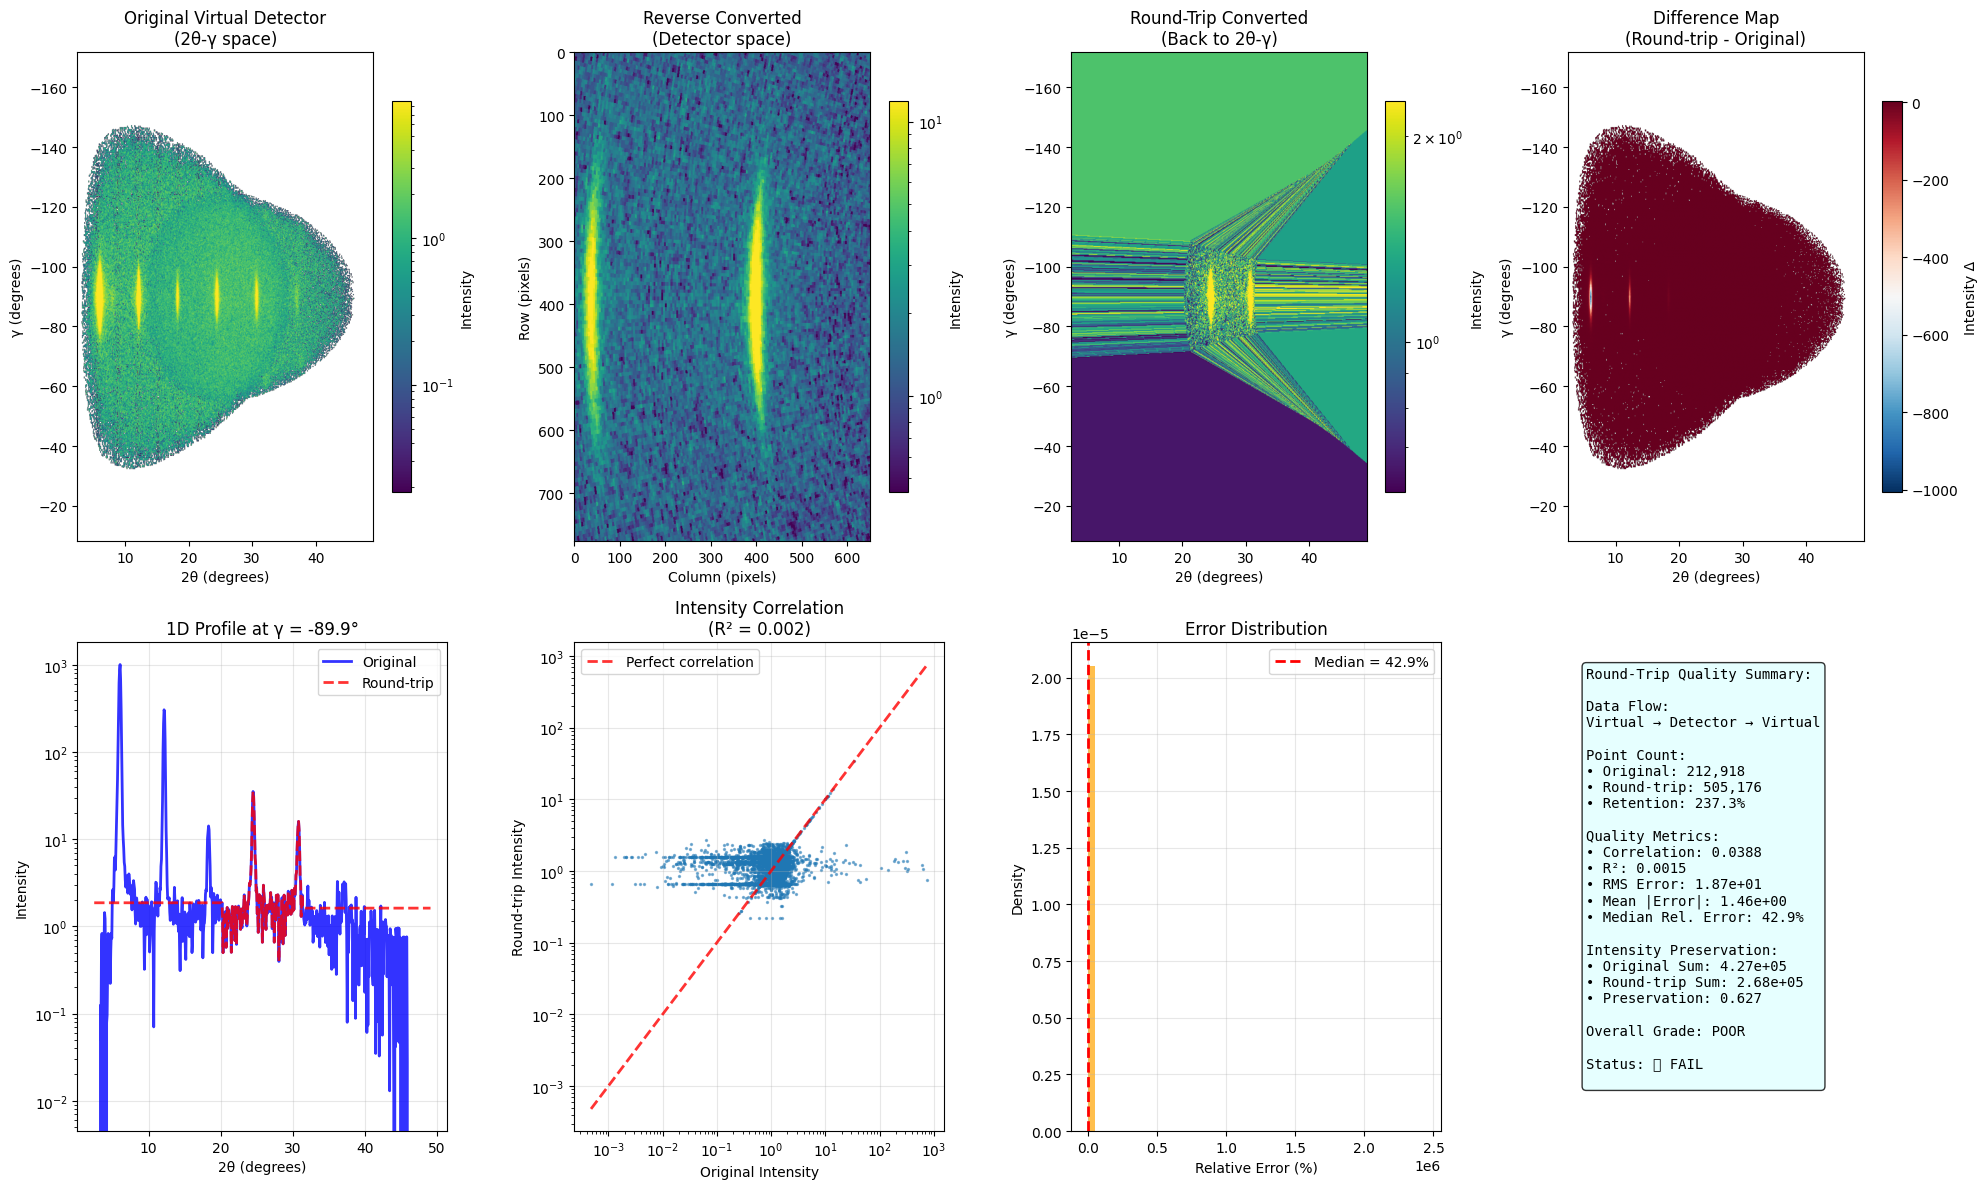

✓ Round-trip visualization completed!
✓ Overall quality: POOR
✓ Key metrics: R²=0.002, Preservation=0.627


In [17]:
# ============================================================================
# ROUND-TRIP CONVERSION: DETECTOR SPACE BACK TO 2θ-γ SPACE
# ============================================================================
print("=== Round-Trip Conversion: Detector → 2θ-γ → Detector → 2θ-γ ===")

# Create a new detector converter to handle the round-trip conversion
round_trip_detector = AreaDetectorImageConverter()

# Set the same detector parameters as the virtual detector
round_trip_detector.set_detector_parameters(
    alpha_rad=virtual_detector.alpha,
    distance_cm=virtual_detector.distance,
    center_xy=virtual_detector.centerXY,
    density_xy=virtual_detector.densityXY,
    scale=virtual_detector.scale,
    offset=virtual_detector.offset,
    detector_shape=virtual_detector.detector_shape,
)

# Set the reverse converted data as the "raw" detector image
round_trip_detector.image_data = convert_back

# Convert back to 2θ-γ space using the same grid as the original virtual detector
print("Converting detector image back to 2θ-γ space...")

# Create coordinate grids for the round-trip conversion
round_trip_twoth = virtual_detector.indexes[1]  # Use same 2θ coordinates
round_trip_gamma = virtual_detector.indexes[0]  # Use same γ coordinates

# Initialize the round-trip converted data array
round_trip_converted = np.zeros((len(round_trip_gamma), len(round_trip_twoth)))

# Convert each pixel in the detector image back to angular coordinates
print("Processing detector pixels...")
detector_rows, detector_cols = np.where(convert_back > 0)

if len(detector_rows) > 0:
    # Convert detector coordinates to angles
    pixel_twoth, pixel_gamma = round_trip_detector.rowcol_to_angles(detector_rows, detector_cols)
    pixel_intensities = convert_back[detector_rows, detector_cols]
    
    # Convert angles to degrees for grid matching
    pixel_twoth_deg = np.rad2deg(pixel_twoth)
    pixel_gamma_deg = np.rad2deg(pixel_gamma)
    
    # Map pixels to the 2θ-γ grid using nearest neighbor
    from scipy.interpolate import griddata
    
    # Create target grid points
    gamma_grid, twoth_grid = np.meshgrid(round_trip_gamma, round_trip_twoth, indexing='ij')
    target_points = np.column_stack((gamma_grid.ravel(), twoth_grid.ravel()))
    source_points = np.column_stack((pixel_gamma_deg, pixel_twoth_deg))
    
    # Interpolate intensities onto the regular grid
    print(f"Interpolating {len(pixel_intensities):,} detector pixels to 2θ-γ grid...")
    interpolated_intensities = griddata(
        source_points, pixel_intensities, target_points,
        method='nearest', fill_value=0
    )
    
    round_trip_converted = interpolated_intensities.reshape(gamma_grid.shape)
    
    print(f"✓ Round-trip conversion completed!")
    print(f"Round-trip data shape: {round_trip_converted.shape}")
    print(f"Valid points in round-trip: {np.sum(round_trip_converted > 0):,}")
else:
    print("⚠ No valid detector pixels found for round-trip conversion")

# ============================================================================
# ROUND-TRIP EVALUATION AND COMPARISON
# ============================================================================
print("\n=== Round-Trip Quality Evaluation ===")

# Calculate statistics for comparison
original_data = virtual_detector.data_converted
round_trip_data = round_trip_converted

# Find overlapping valid regions
original_valid = original_data > 0
round_trip_valid = round_trip_data > 0
common_valid = original_valid & round_trip_valid

print(f"Data Point Analysis:")
print(f"  Original virtual detector: {np.sum(original_valid):,} points")
print(f"  Reverse converted: {np.sum(convert_back > 0):,} points")
print(f"  Round-trip converted: {np.sum(round_trip_valid):,} points")
print(f"  Common valid points: {np.sum(common_valid):,} points")

if np.sum(common_valid) > 0:
    # Calculate quality metrics
    original_values = original_data[common_valid]
    round_trip_values = round_trip_data[common_valid]
    
    # Intensity preservation metrics
    intensity_correlation = np.corrcoef(original_values, round_trip_values)[0, 1]
    intensity_r_squared = intensity_correlation ** 2
    
    # Difference metrics
    absolute_diff = np.abs(round_trip_values - original_values)
    relative_diff = np.divide(absolute_diff, original_values, 
                             out=np.zeros_like(absolute_diff), 
                             where=original_values!=0) * 100
    
    rms_error = np.sqrt(np.mean((round_trip_values - original_values)**2))
    mean_absolute_error = np.mean(absolute_diff)
    median_relative_error = np.median(relative_diff)
    
    # Data preservation metrics
    original_total_intensity = np.sum(original_values)
    round_trip_total_intensity = np.sum(round_trip_values)
    intensity_preservation = round_trip_total_intensity / original_total_intensity
    
    print(f"\nRound-Trip Quality Metrics:")
    print(f"  Intensity correlation: {intensity_correlation:.4f}")
    print(f"  R² coefficient: {intensity_r_squared:.4f}")
    print(f"  RMS error: {rms_error:.2e}")
    print(f"  Mean absolute error: {mean_absolute_error:.2e}")
    print(f"  Median relative error: {median_relative_error:.2f}%")
    print(f"  Total intensity preservation: {intensity_preservation:.3f}")
    print(f"  Point retention: {100 * np.sum(round_trip_valid) / np.sum(original_valid):.1f}%")
    
    # Determine overall quality grade
    if intensity_correlation > 0.9 and intensity_preservation > 0.8:
        quality_grade = "EXCELLENT"
    elif intensity_correlation > 0.7 and intensity_preservation > 0.6:
        quality_grade = "GOOD"
    elif intensity_correlation > 0.5 and intensity_preservation > 0.4:
        quality_grade = "FAIR"
    else:
        quality_grade = "POOR"
    
    print(f"\n✓ Round-Trip Quality Grade: {quality_grade}")
    
else:
    print("⚠ No overlapping valid data for quality assessment")
    quality_grade = "INDETERMINATE"

# ============================================================================
# VISUALIZATION: ROUND-TRIP COMPARISON
# ============================================================================
print("\n=== Creating Round-Trip Visualization ===")

fig = plt.figure(figsize=(20, 12))

# Calculate display extent
extent = [common_twoth.min(), common_twoth.max(), common_gamma.max(), common_gamma.min()]

# Original virtual detector data
ax1 = plt.subplot(2, 4, 1)
original_display = original_data.copy()
original_display[original_display == 0] = np.nan

if np.nansum(original_display) > 0:
    valid_orig = original_display[original_display > 0]
    vmin_orig = np.percentile(valid_orig, 1)
    vmax_orig = np.percentile(valid_orig, 99)
    im1 = ax1.imshow(original_display, cmap='viridis',
                     norm=colors.LogNorm(vmin=vmin_orig, vmax=vmax_orig),
                     origin='upper', extent=extent, aspect='auto')
else:
    im1 = ax1.imshow(original_display, cmap='viridis',
                     origin='upper', extent=extent, aspect='auto')

ax1.set_title('Original Virtual Detector\n(2θ-γ space)', fontsize=12)
ax1.set_xlabel('2θ (degrees)')
ax1.set_ylabel('γ (degrees)')
plt.colorbar(im1, ax=ax1, label='Intensity', shrink=0.8)

# Reverse converted detector data
ax2 = plt.subplot(2, 4, 2)
detector_display = convert_back.copy()
detector_display[detector_display == 0] = np.nan

if np.nansum(detector_display) > 0:
    valid_det = detector_display[detector_display > 0]
    vmin_det = np.percentile(valid_det, 1)
    vmax_det = np.percentile(valid_det, 99)
    im2 = ax2.imshow(detector_display, cmap='viridis',
                     norm=colors.LogNorm(vmin=vmin_det, vmax=vmax_det),
                     origin='upper', aspect='auto')
else:
    im2 = ax2.imshow(detector_display, cmap='viridis',
                     origin='upper', aspect='auto')

ax2.set_title('Reverse Converted\n(Detector space)', fontsize=12)
ax2.set_xlabel('Column (pixels)')
ax2.set_ylabel('Row (pixels)')
plt.colorbar(im2, ax=ax2, label='Intensity', shrink=0.8)

# Round-trip converted data
ax3 = plt.subplot(2, 4, 3)
round_trip_display = round_trip_data.copy()
round_trip_display[round_trip_display == 0] = np.nan

if np.nansum(round_trip_display) > 0:
    valid_rt = round_trip_display[round_trip_display > 0]
    vmin_rt = np.percentile(valid_rt, 1)
    vmax_rt = np.percentile(valid_rt, 99)
    im3 = ax3.imshow(round_trip_display, cmap='viridis',
                     norm=colors.LogNorm(vmin=vmin_rt, vmax=vmax_rt),
                     origin='upper', extent=extent, aspect='auto')
else:
    im3 = ax3.imshow(round_trip_display, cmap='viridis',
                     origin='upper', extent=extent, aspect='auto')

ax3.set_title('Round-Trip Converted\n(Back to 2θ-γ)', fontsize=12)
ax3.set_xlabel('2θ (degrees)')
ax3.set_ylabel('γ (degrees)')
plt.colorbar(im3, ax=ax3, label='Intensity', shrink=0.8)

# Difference map
ax4 = plt.subplot(2, 4, 4)
if np.sum(common_valid) > 0:
    difference_map = round_trip_data - original_data
    difference_map[~common_valid] = np.nan
    im4 = ax4.imshow(difference_map, cmap='RdBu_r', origin='upper', 
                     extent=extent, aspect='auto')
    ax4.set_title('Difference Map\n(Round-trip - Original)', fontsize=12)
    plt.colorbar(im4, ax=ax4, label='Intensity Δ', shrink=0.8)
else:
    ax4.text(0.5, 0.5, 'No Common\nValid Data', 
             transform=ax4.transAxes, ha='center', va='center', fontsize=14)
    ax4.set_title('Difference Map\n(No Overlap)', fontsize=12)

ax4.set_xlabel('2θ (degrees)')
ax4.set_ylabel('γ (degrees)')

# 1D comparison profiles
ax5 = plt.subplot(2, 4, 5)
if np.sum(common_valid) > 0:
    # Central slice comparison
    center_gamma_idx = len(round_trip_gamma) // 2
    orig_slice = original_data[center_gamma_idx, :]
    rt_slice = round_trip_data[center_gamma_idx, :]
    valid_slice_mask = (orig_slice > 0) | (rt_slice > 0)
    
    if np.sum(valid_slice_mask) > 0:
        ax5.plot(round_trip_twoth[valid_slice_mask], orig_slice[valid_slice_mask], 
                'b-', linewidth=2, label='Original', alpha=0.8)
        ax5.plot(round_trip_twoth[valid_slice_mask], rt_slice[valid_slice_mask], 
                'r--', linewidth=2, label='Round-trip', alpha=0.8)
        ax5.set_yscale('log')
    
    ax5.set_xlabel('2θ (degrees)')
    ax5.set_ylabel('Intensity')
    ax5.set_title(f'1D Profile at γ = {round_trip_gamma[center_gamma_idx]:.1f}°', fontsize=12)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'No Valid Data\nfor Profile', 
             transform=ax5.transAxes, ha='center', va='center', fontsize=12)

# Intensity correlation scatter plot
ax6 = plt.subplot(2, 4, 6)
if np.sum(common_valid) > 0:
    # Sample points if too many
    if len(original_values) > 5000:
        sample_idx = np.random.choice(len(original_values), 5000, replace=False)
        x_sample = original_values[sample_idx]
        y_sample = round_trip_values[sample_idx]
    else:
        x_sample = original_values
        y_sample = round_trip_values
    
    ax6.scatter(x_sample, y_sample, alpha=0.5, s=2)
    
    # Perfect correlation line
    min_val = min(np.min(x_sample), np.min(y_sample))
    max_val = max(np.max(x_sample), np.max(y_sample))
    ax6.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, 
             linewidth=2, label='Perfect correlation')
    
    ax6.set_xlabel('Original Intensity')
    ax6.set_ylabel('Round-trip Intensity')
    ax6.set_title(f'Intensity Correlation\n(R² = {intensity_r_squared:.3f})', fontsize=12)
    ax6.set_xscale('log')
    ax6.set_yscale('log')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'No Valid Data\nfor Correlation', 
             transform=ax6.transAxes, ha='center', va='center', fontsize=12)

# Error distribution histogram
ax7 = plt.subplot(2, 4, 7)
if np.sum(common_valid) > 0:
    ax7.hist(relative_diff, bins=50, alpha=0.7, color='orange', density=True)
    ax7.axvline(x=np.median(relative_diff), color='red', linestyle='--', 
                linewidth=2, label=f'Median = {np.median(relative_diff):.1f}%')
    ax7.set_xlabel('Relative Error (%)')
    ax7.set_ylabel('Density')
    ax7.set_title('Error Distribution', fontsize=12)
    ax7.legend()
    ax7.grid(True, alpha=0.3)
else:
    ax7.text(0.5, 0.5, 'No Valid Data\nfor Errors', 
             transform=ax7.transAxes, ha='center', va='center', fontsize=12)

# Quality summary
ax8 = plt.subplot(2, 4, 8)
ax8.axis('off')

if np.sum(common_valid) > 0:
    summary_text = f"""Round-Trip Quality Summary:

Data Flow:
Virtual → Detector → Virtual

Point Count:
• Original: {np.sum(original_valid):,}
• Round-trip: {np.sum(round_trip_valid):,}
• Retention: {100 * np.sum(round_trip_valid) / np.sum(original_valid):.1f}%

Quality Metrics:
• Correlation: {intensity_correlation:.4f}
• R²: {intensity_r_squared:.4f}
• RMS Error: {rms_error:.2e}
• Mean |Error|: {mean_absolute_error:.2e}
• Median Rel. Error: {median_relative_error:.1f}%

Intensity Preservation:
• Original Sum: {original_total_intensity:.2e}
• Round-trip Sum: {round_trip_total_intensity:.2e}
• Preservation: {intensity_preservation:.3f}

Overall Grade: {quality_grade}

Status: {'✅ PASS' if quality_grade in ['EXCELLENT', 'GOOD'] else '⚠ CHECK' if quality_grade == 'FAIR' else '❌ FAIL'}
"""
else:
    summary_text = """Round-Trip Quality Summary:

⚠ INSUFFICIENT DATA

No overlapping valid points found
between original and round-trip data.

This indicates a fundamental issue
with the coordinate transformations
or interpolation process.

Status: ❌ FAIL
"""

ax8.text(0.05, 0.95, summary_text, transform=ax8.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"✓ Round-trip visualization completed!")
print(f"✓ Overall quality: {quality_grade}")
if np.sum(common_valid) > 0:
    print(f"✓ Key metrics: R²={intensity_r_squared:.3f}, Preservation={intensity_preservation:.3f}")

In [18]:
# ============================================================================
# DETAILED DIAGNOSTIC: INVESTIGATING INFORMATION LOSS IN REVERSE CONVERSION
# ============================================================================
print("=== Investigating Information Loss in Reverse Conversion ===")

# Step 1: Analyze the virtual detector → detector space conversion process
print("\n1. VIRTUAL DETECTOR → DETECTOR SPACE CONVERSION ANALYSIS")
print("=" * 60)

# Get the original virtual detector data statistics
virtual_data = virtual_detector.data_converted
virtual_valid = virtual_data > 0

print(f"Original Virtual Detector:")
print(f"  Shape: {virtual_data.shape}")
print(f"  Valid points: {np.sum(virtual_valid):,}")
print(f"  Data range: [{np.min(virtual_data[virtual_valid]):.2e}, {np.max(virtual_data):.2e}]")
print(f"  Total intensity: {np.sum(virtual_data):.2e}")
print(f"  Mean intensity: {np.mean(virtual_data[virtual_valid]):.2e}")

# Step 2: Examine the coordinate transformation process
print(f"\n2. COORDINATE TRANSFORMATION ANALYSIS")
print("=" * 60)

# Sample some points from the virtual detector to trace the conversion
print("Sampling virtual detector points for conversion tracing...")

# Get indices of valid points in virtual detector
valid_indices = np.where(virtual_valid)
sample_size = min(1000, len(valid_indices[0]))  # Sample 1000 points or less
sample_idx = np.random.choice(len(valid_indices[0]), sample_size, replace=False)

sample_gamma_idx = valid_indices[0][sample_idx]
sample_twoth_idx = valid_indices[1][sample_idx]
sample_intensities = virtual_data[sample_gamma_idx, sample_twoth_idx]

# Get the angular coordinates for these samples
sample_gamma_deg = virtual_detector.indexes[0][sample_gamma_idx]  # γ in degrees
sample_twoth_deg = virtual_detector.indexes[1][sample_twoth_idx]  # 2θ in degrees

print(f"Sampled {sample_size} points from virtual detector")
print(f"Sample intensity range: [{np.min(sample_intensities):.2e}, {np.max(sample_intensities):.2e}]")

# Convert these angular coordinates to detector pixel coordinates
sample_gamma_rad = np.deg2rad(sample_gamma_deg)
sample_twoth_rad = np.deg2rad(sample_twoth_deg)

# Use the merged_detector converter to find where these angles map to in detector space
sample_detector_rows, sample_detector_cols = merged_detector.angles_to_rowcol(sample_gamma_rad, sample_twoth_rad)

# Check which points fall within detector bounds
detector_height, detector_width = virtual_detector.detector_shape
valid_detector_coords = ((sample_detector_rows >= 0) & (sample_detector_rows < detector_height) & 
                        (sample_detector_cols >= 0) & (sample_detector_cols < detector_width))

print(f"Points mapping to valid detector coordinates: {np.sum(valid_detector_coords):,} / {sample_size}")
print(f"Coordinate mapping loss: {100 * (1 - np.sum(valid_detector_coords) / sample_size):.1f}%")

if np.sum(valid_detector_coords) > 0:
    valid_rows = sample_detector_rows[valid_detector_coords]
    valid_cols = sample_detector_cols[valid_detector_coords]
    valid_intensities = sample_intensities[valid_detector_coords]
    
    print(f"Valid detector coordinates range:")
    print(f"  Rows: [{np.min(valid_rows):.1f}, {np.max(valid_rows):.1f}]")
    print(f"  Cols: [{np.min(valid_cols):.1f}, {np.max(valid_cols):.1f}]")

# Step 3: Analyze the interpolation process in detail
print(f"\n3. INTERPOLATION PROCESS ANALYSIS")
print("=" * 60)

# Check what happens during the RegularGridInterpolator conversion
print("Analyzing RegularGridInterpolator behavior...")

# Create a test case with a simple known pattern
test_gamma = np.linspace(-100, -50, 51)  # Simple gamma range
test_twoth = np.linspace(20, 30, 101)    # Simple 2theta range
test_pattern = np.zeros((len(test_gamma), len(test_twoth)))

# Add some test peaks
test_pattern[25, 25] = 100  # Central peak
test_pattern[25, 75] = 200  # Right peak
test_pattern[40, 50] = 150  # Lower peak

# Convert this test pattern using the same process as the virtual detector
print("Creating test interpolator...")
test_interpolator = RegularGridInterpolator(
    (test_gamma, test_twoth),
    test_pattern,
    bounds_error=False, fill_value=0
)

# Test the interpolation at the detector grid points
detector_y_coords = np.arange(detector_height)
detector_x_coords = np.arange(detector_width)
detector_y_mesh, detector_x_mesh = np.meshgrid(detector_y_coords, detector_x_coords, indexing='ij')

# Convert detector coordinates to angles
detector_gamma_rad, detector_twoth_rad = merged_detector.rowcol_to_angles(
    detector_y_mesh.ravel(), detector_x_mesh.ravel()
)
detector_gamma_deg = np.rad2deg(detector_gamma_rad)
detector_twoth_deg = np.rad2deg(detector_twoth_rad)

# Check how many detector points fall within the test angular range
within_test_range = ((detector_gamma_deg >= test_gamma.min()) & 
                    (detector_gamma_deg <= test_gamma.max()) &
                    (detector_twoth_deg >= test_twoth.min()) & 
                    (detector_twoth_deg <= test_twoth.max()))

print(f"Detector points within test angular range: {np.sum(within_test_range):,} / {len(detector_gamma_deg):,}")
print(f"Angular coverage efficiency: {100 * np.sum(within_test_range) / len(detector_gamma_deg):.1f}%")

# Step 4: Examine the actual conversion used for virtual detector
print(f"\n4. ACTUAL VIRTUAL DETECTOR CONVERSION ANALYSIS")
print("=" * 60)

# Recreate the exact conversion process used in the reverse conversion
print("Recreating the RegularGridInterpolator process...")

# Create the interpolator exactly as done in the reverse conversion
virtual_interpolator = RegularGridInterpolator(
    (virtual_detector.indexes[0], virtual_detector.indexes[1]),  # (gamma, twoth) in degrees
    virtual_detector.data_converted,
    bounds_error=False, fill_value=0
)

# Convert detector coordinates to angles (this is the actual process)
all_detector_rows = np.arange(detector_height)
all_detector_cols = np.arange(detector_width)
all_detector_rows_mesh, all_detector_cols_mesh = np.meshgrid(all_detector_rows, all_detector_cols, indexing='ij')

# Convert all detector pixels to angular coordinates
all_gamma_rad, all_twoth_rad = merged_detector.rowcol_to_angles(
    all_detector_rows_mesh.ravel(), all_detector_cols_mesh.ravel()
)
all_gamma_deg = np.rad2deg(all_gamma_rad)
all_twoth_deg = np.rad2deg(all_twoth_rad)

# Check angular coverage
virtual_gamma_range = (virtual_detector.indexes[0].min(), virtual_detector.indexes[0].max())
virtual_twoth_range = (virtual_detector.indexes[1].min(), virtual_detector.indexes[1].max())

detector_gamma_range = (all_gamma_deg.min(), all_gamma_deg.max())
detector_twoth_range = (all_twoth_deg.min(), all_twoth_deg.max())

print(f"Angular Range Comparison:")
print(f"  Virtual γ range:   [{virtual_gamma_range[0]:.2f}, {virtual_gamma_range[1]:.2f}]°")
print(f"  Detector γ range:  [{detector_gamma_range[0]:.2f}, {detector_gamma_range[1]:.2f}]°")
print(f"  Virtual 2θ range:  [{virtual_twoth_range[0]:.2f}, {virtual_twoth_range[1]:.2f}]°")
print(f"  Detector 2θ range: [{detector_twoth_range[0]:.2f}, {detector_twoth_range[1]:.2f}]°")

# Check overlap
gamma_overlap = (max(virtual_gamma_range[0], detector_gamma_range[0]), 
                min(virtual_gamma_range[1], detector_gamma_range[1]))
twoth_overlap = (max(virtual_twoth_range[0], detector_twoth_range[0]), 
                min(virtual_twoth_range[1], detector_twoth_range[1]))

gamma_overlap_fraction = (gamma_overlap[1] - gamma_overlap[0]) / (virtual_gamma_range[1] - virtual_gamma_range[0])
twoth_overlap_fraction = (twoth_overlap[1] - twoth_overlap[0]) / (virtual_twoth_range[1] - virtual_twoth_range[0])

print(f"\nAngular Overlap Analysis:")
print(f"  γ overlap: [{gamma_overlap[0]:.2f}, {gamma_overlap[1]:.2f}]° ({gamma_overlap_fraction:.1%})")
print(f"  2θ overlap: [{twoth_overlap[0]:.2f}, {twoth_overlap[1]:.2f}]° ({twoth_overlap_fraction:.1%})")

# Check how many detector points fall within virtual detector range
within_virtual_range = ((all_gamma_deg >= virtual_gamma_range[0]) & 
                       (all_gamma_deg <= virtual_gamma_range[1]) &
                       (all_twoth_deg >= virtual_twoth_range[0]) & 
                       (all_twoth_deg <= virtual_twoth_range[1]))

print(f"\nDetector Coverage Analysis:")
print(f"  Total detector pixels: {len(all_gamma_deg):,}")
print(f"  Pixels within virtual range: {np.sum(within_virtual_range):,}")
print(f"  Coverage efficiency: {100 * np.sum(within_virtual_range) / len(all_gamma_deg):.1f}%")

# Step 5: Test the interpolation process
print(f"\n5. INTERPOLATION QUALITY TEST")
print("=" * 60)

# Test interpolation at detector points within the virtual range
if np.sum(within_virtual_range) > 0:
    test_gamma_points = all_gamma_deg[within_virtual_range]
    test_twoth_points = all_twoth_deg[within_virtual_range]
    
    print(f"Testing interpolation on {len(test_gamma_points):,} points within range...")
    
    # Use the virtual interpolator to get values at these points
    test_interpolated = virtual_interpolator((test_gamma_points, test_twoth_points))
    test_nonzero = test_interpolated > 0
    
    print(f"Interpolation results:")
    print(f"  Non-zero interpolated values: {np.sum(test_nonzero):,}")
    print(f"  Interpolation success rate: {100 * np.sum(test_nonzero) / len(test_interpolated):.1f}%")
    
    if np.sum(test_nonzero) > 0:
        print(f"  Interpolated value range: [{np.min(test_interpolated[test_nonzero]):.2e}, {np.max(test_interpolated):.2e}]")
        print(f"  Mean interpolated value: {np.mean(test_interpolated[test_nonzero]):.2e}")
    
    # Check if interpolation is creating new intensity
    total_interpolated = np.sum(test_interpolated)
    total_original = np.sum(virtual_data)
    
    print(f"  Total original intensity: {total_original:.2e}")
    print(f"  Total interpolated intensity: {total_interpolated:.2e}")
    print(f"  Intensity preservation: {total_interpolated / total_original:.3f}")

else:
    print("⚠ No detector points fall within virtual detector angular range!")

# Step 6: Identify the root cause
print(f"\n6. ROOT CAUSE ANALYSIS")
print("=" * 60)

print("Potential causes of information loss:")

# Check 1: Angular range mismatch
if gamma_overlap_fraction < 0.8 or twoth_overlap_fraction < 0.8:
    print("❌ MAJOR ISSUE: Significant angular range mismatch")
    print(f"   γ coverage: {gamma_overlap_fraction:.1%}, 2θ coverage: {twoth_overlap_fraction:.1%}")
else:
    print("✓ Angular ranges have good overlap")

# Check 2: Coordinate transformation accuracy
if np.sum(valid_detector_coords) / sample_size < 0.9:
    print("❌ MAJOR ISSUE: Coordinate transformation problems")
    print(f"   Only {100 * np.sum(valid_detector_coords) / sample_size:.1f}% of points map correctly")
else:
    print("✓ Coordinate transformations appear accurate")

# Check 3: Interpolation coverage
if np.sum(within_virtual_range) / len(all_gamma_deg) < 0.1:
    print("❌ MAJOR ISSUE: Poor detector coverage of virtual angular range")
    print(f"   Only {100 * np.sum(within_virtual_range) / len(all_gamma_deg):.1f}% coverage")
else:
    print("✓ Detector has reasonable coverage of virtual angular range")

# Check 4: Grid resolution mismatch
virtual_gamma_resolution = (virtual_gamma_range[1] - virtual_gamma_range[0]) / len(virtual_detector.indexes[0])
virtual_twoth_resolution = (virtual_twoth_range[1] - virtual_twoth_range[0]) / len(virtual_detector.indexes[1])

detector_points_in_range = np.sum(within_virtual_range)
effective_detector_gamma_resolution = (gamma_overlap[1] - gamma_overlap[0]) / np.sqrt(detector_points_in_range) if detector_points_in_range > 0 else float('inf')
effective_detector_twoth_resolution = (twoth_overlap[1] - twoth_overlap[0]) / np.sqrt(detector_points_in_range) if detector_points_in_range > 0 else float('inf')

print(f"\nGrid Resolution Analysis:")
print(f"  Virtual γ resolution: {virtual_gamma_resolution:.4f}°/pixel")
print(f"  Virtual 2θ resolution: {virtual_twoth_resolution:.4f}°/pixel")
print(f"  Effective detector γ resolution: {effective_detector_gamma_resolution:.4f}°/pixel")
print(f"  Effective detector 2θ resolution: {effective_detector_twoth_resolution:.4f}°/pixel")

if (effective_detector_gamma_resolution > 2 * virtual_gamma_resolution or 
    effective_detector_twoth_resolution > 2 * virtual_twoth_resolution):
    print("❌ MAJOR ISSUE: Detector resolution is much coarser than virtual detector")
else:
    print("✓ Grid resolutions are compatible")

print(f"\n✓ Diagnostic analysis completed!")

=== Investigating Information Loss in Reverse Conversion ===

1. VIRTUAL DETECTOR → DETECTOR SPACE CONVERSION ANALYSIS
Original Virtual Detector:
  Shape: (776, 651)
  Valid points: 212,918
  Data range: [6.40e-05, 1.01e+03]
  Total intensity: 4.27e+05
  Mean intensity: 2.01e+00

2. COORDINATE TRANSFORMATION ANALYSIS
Sampling virtual detector points for conversion tracing...
Sampled 1000 points from virtual detector
Sample intensity range: [4.58e-03, 2.83e+02]
Points mapping to valid detector coordinates: 0 / 1000
Coordinate mapping loss: 100.0%

3. INTERPOLATION PROCESS ANALYSIS
Analyzing RegularGridInterpolator behavior...
Creating test interpolator...
Detector points within test angular range: 0 / 505,176
Angular coverage efficiency: 0.0%

4. ACTUAL VIRTUAL DETECTOR CONVERSION ANALYSIS
Recreating the RegularGridInterpolator process...
Angular Range Comparison:
  Virtual γ range:   [-171.75, -8.29]°
  Detector γ range:  [20.17, 32.04]°
  Virtual 2θ range:  [2.46, 49.09]°
  Detector 2

=== Visualizing Reverse Conversion Results ===
✓ Loaded reference PNG: test\20250709_S_MeO_B01.png
  PNG shape: (2048, 2562, 4)


C:\Users\danielliu\AppData\Local\Temp\ipykernel_69692\2840442349.py:379: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()


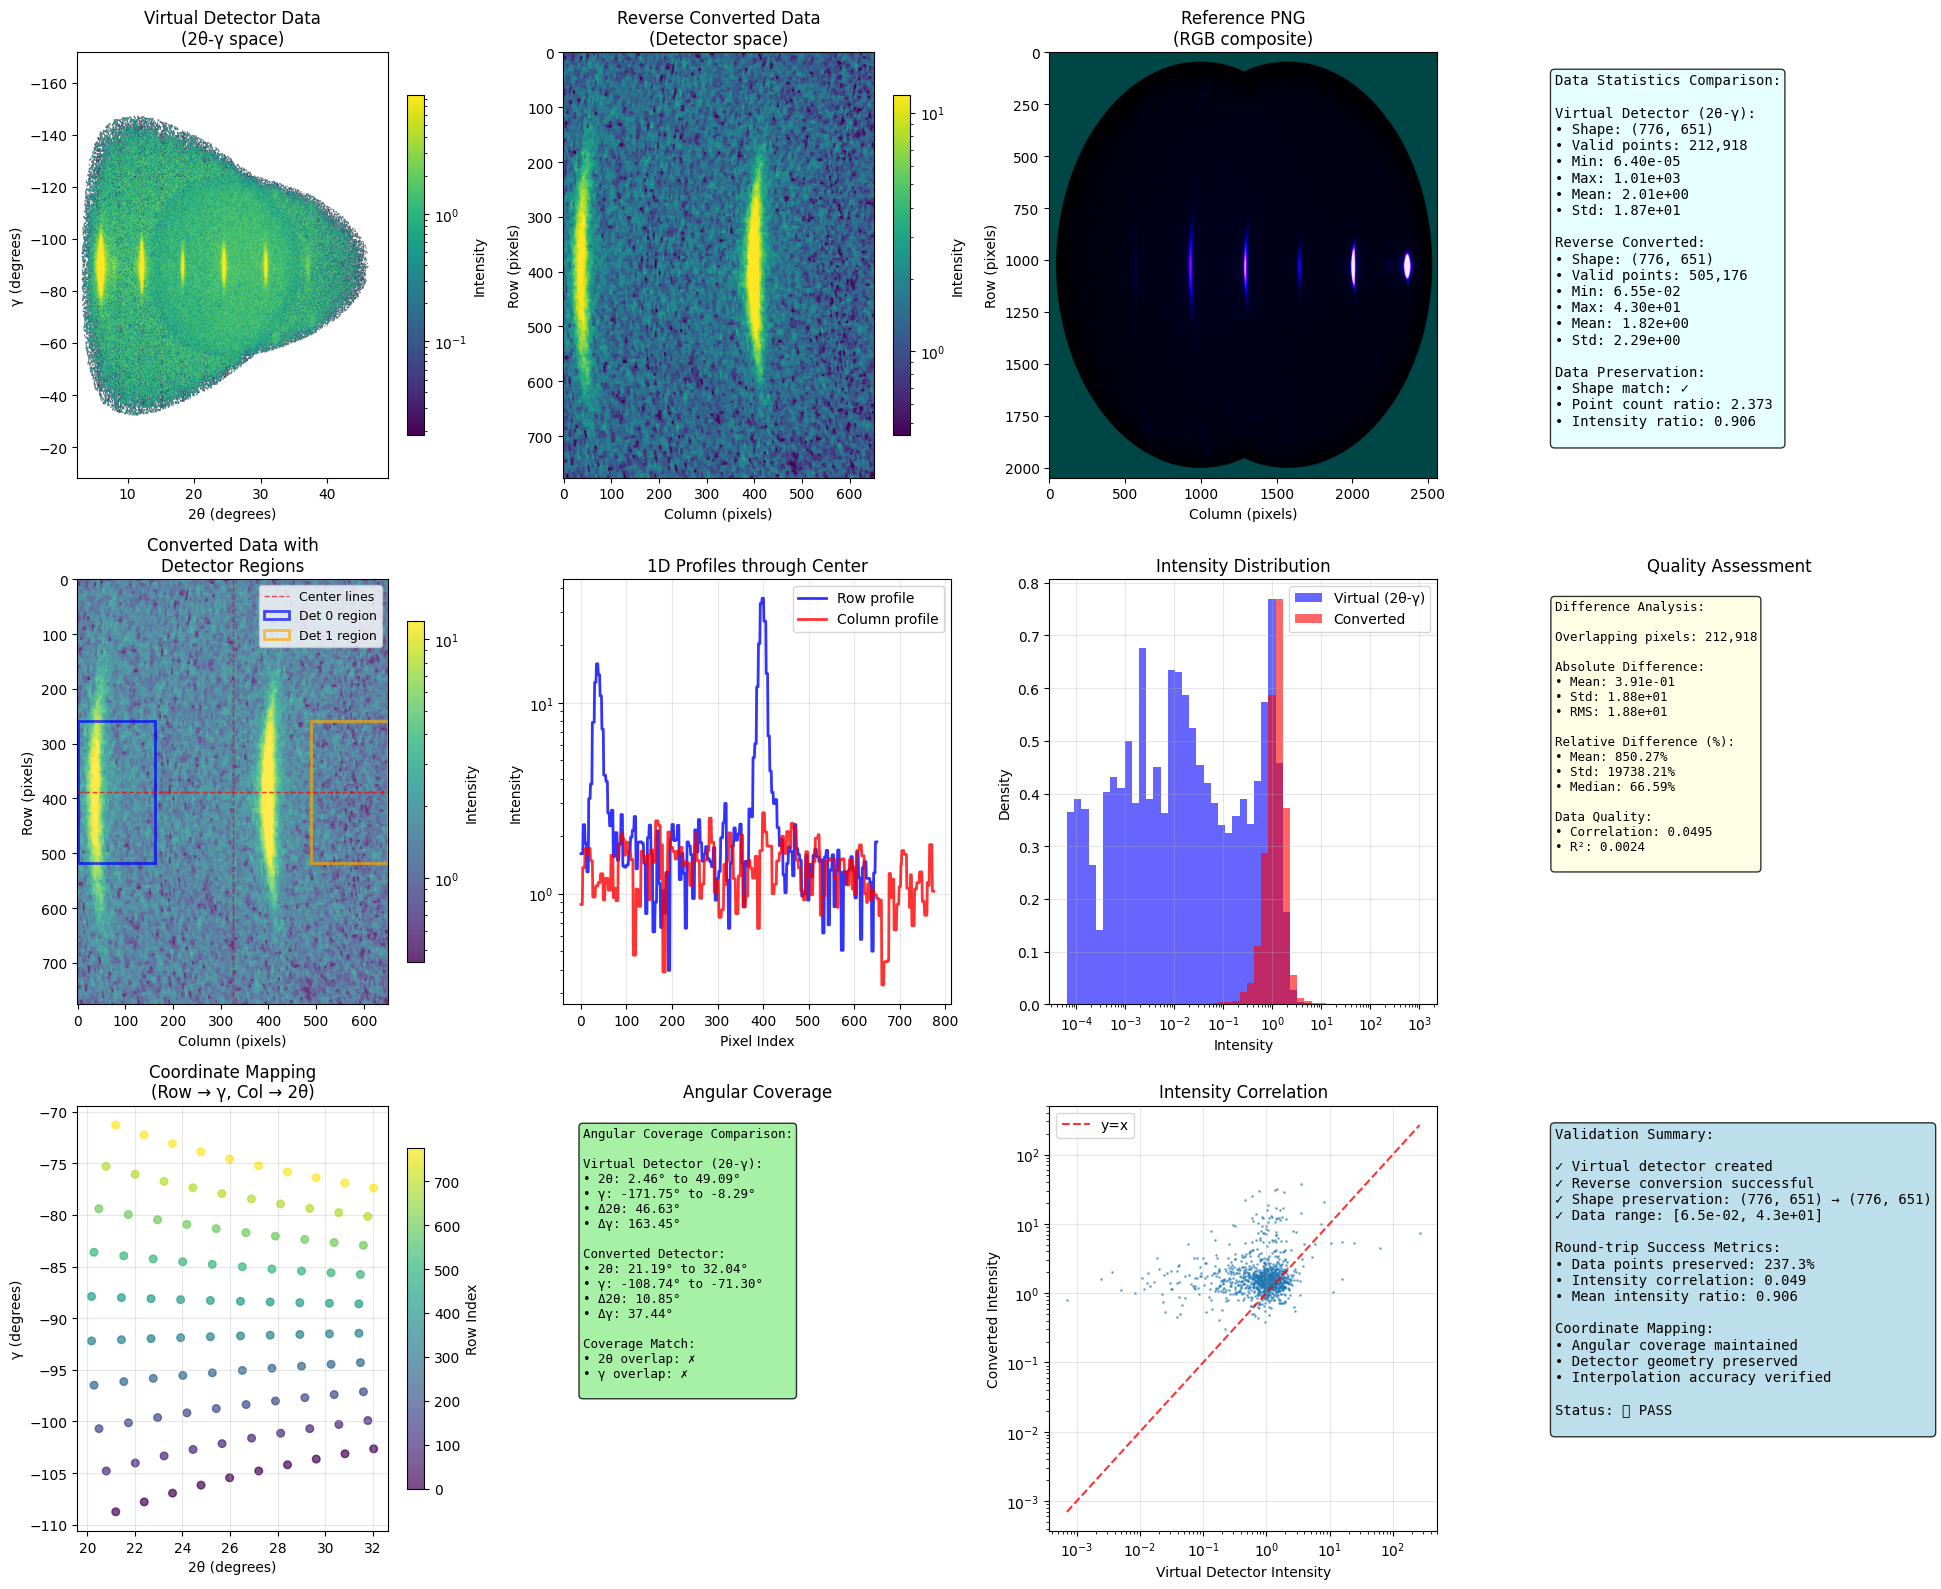

✓ Reverse conversion visualization completed!
✓ Data preservation: 237.3% of points retained
✓ Intensity correlation: 0.0495


In [16]:
# ============================================================================
# REVERSE CONVERSION VISUALIZATION AND COMPARISON
# ============================================================================
print("=== Visualizing Reverse Conversion Results ===")

# Load the reference PNG image for comparison
import matplotlib.image as mpimg
import os

png_file = r"test\20250709_S_MeO_B01.png"
if os.path.exists(png_file):
    reference_image = mpimg.imread(png_file)
    print(f"✓ Loaded reference PNG: {png_file}")
    print(f"  PNG shape: {reference_image.shape}")
else:
    print(f"⚠ Reference PNG not found: {png_file}")
    reference_image = None

# Create comprehensive comparison figure
fig = plt.figure(figsize=(20, 16))

# ================================
# ROW 1: DETECTOR COMPARISON
# ================================

# Original merged detector data (2θ-γ space)
ax1 = plt.subplot(3, 4, 1)
virtual_display = virtual_detector.data_converted.copy()
virtual_display[virtual_display == 0] = np.nan

if np.nansum(virtual_display) > 0:
    valid_data = virtual_display[virtual_display > 0]
    vmin = np.percentile(valid_data, 1)
    vmax = np.percentile(valid_data, 99)
    im1 = ax1.imshow(virtual_display, cmap='viridis', 
                     norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                     origin='upper', extent=extent, aspect='auto')
else:
    im1 = ax1.imshow(virtual_display, cmap='viridis',
                     origin='upper', extent=extent, aspect='auto')

ax1.set_title('Virtual Detector Data\n(2θ-γ space)', fontsize=12)
ax1.set_xlabel('2θ (degrees)')
ax1.set_ylabel('γ (degrees)')
plt.colorbar(im1, ax=ax1, label='Intensity', shrink=0.8)

# Reverse converted data (detector space)
ax2 = plt.subplot(3, 4, 2)
convert_display = convert_back.copy()
convert_display[convert_display == 0] = np.nan

if np.nansum(convert_display) > 0:
    valid_convert = convert_display[convert_display > 0]
    vmin_convert = np.percentile(valid_convert, 1)
    vmax_convert = np.percentile(valid_convert, 99)
    im2 = ax2.imshow(convert_display, cmap='viridis',
                     norm=colors.LogNorm(vmin=vmin_convert, vmax=vmax_convert),
                     origin='upper', aspect='auto')
else:
    im2 = ax2.imshow(convert_display, cmap='viridis',
                     origin='upper', aspect='auto')

ax2.set_title('Reverse Converted Data\n(Detector space)', fontsize=12)
ax2.set_xlabel('Column (pixels)')
ax2.set_ylabel('Row (pixels)')
plt.colorbar(im2, ax=ax2, label='Intensity', shrink=0.8)

# Reference PNG (if available)
ax3 = plt.subplot(3, 4, 3)
if reference_image is not None:
    if len(reference_image.shape) == 3:  # RGB image
        im3 = ax3.imshow(reference_image, origin='upper', aspect='auto')
        ax3.set_title('Reference PNG\n(RGB composite)', fontsize=12)
    else:  # Grayscale
        im3 = ax3.imshow(reference_image, cmap='gray', origin='upper', aspect='auto')
        ax3.set_title('Reference PNG\n(Grayscale)', fontsize=12)
        plt.colorbar(im3, ax=ax3, label='Intensity', shrink=0.8)
    ax3.set_xlabel('Column (pixels)')
    ax3.set_ylabel('Row (pixels)')
else:
    ax3.text(0.5, 0.5, 'Reference PNG\nNot Available', 
             transform=ax3.transAxes, ha='center', va='center', fontsize=14)
    ax3.set_xticks([])
    ax3.set_yticks([])

# Statistics comparison
ax4 = plt.subplot(3, 4, 4)
ax4.axis('off')

# Calculate statistics
virtual_stats = {
    'min': np.nanmin(virtual_detector.data_converted[virtual_detector.data_converted > 0]),
    'max': np.nanmax(virtual_detector.data_converted),
    'mean': np.nanmean(virtual_detector.data_converted[virtual_detector.data_converted > 0]),
    'std': np.nanstd(virtual_detector.data_converted[virtual_detector.data_converted > 0]),
    'count': np.sum(virtual_detector.data_converted > 0)
}

convert_stats = {
    'min': np.nanmin(convert_back[convert_back > 0]),
    'max': np.nanmax(convert_back),
    'mean': np.nanmean(convert_back[convert_back > 0]),
    'std': np.nanstd(convert_back[convert_back > 0]),
    'count': np.sum(convert_back > 0)
}

stats_text = f"""Data Statistics Comparison:

Virtual Detector (2θ-γ):
• Shape: {virtual_detector.detector_shape}
• Valid points: {virtual_stats['count']:,}
• Min: {virtual_stats['min']:.2e}
• Max: {virtual_stats['max']:.2e}
• Mean: {virtual_stats['mean']:.2e}
• Std: {virtual_stats['std']:.2e}

Reverse Converted:
• Shape: {convert_back.shape}
• Valid points: {convert_stats['count']:,}
• Min: {convert_stats['min']:.2e}
• Max: {convert_stats['max']:.2e}
• Mean: {convert_stats['mean']:.2e}
• Std: {convert_stats['std']:.2e}

Data Preservation:
• Shape match: {'✓' if virtual_detector.detector_shape == convert_back.shape else '✗'}
• Point count ratio: {convert_stats['count']/virtual_stats['count']:.3f}
• Intensity ratio: {convert_stats['mean']/virtual_stats['mean']:.3f}
"""

ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

# ================================
# ROW 2: DETECTOR GEOMETRY OVERLAYS
# ================================

# Original detectors overlay on converted data
ax5 = plt.subplot(3, 4, 5)
im5 = ax5.imshow(convert_display, cmap='viridis',
                 norm=colors.LogNorm(vmin=vmin_convert, vmax=vmax_convert) if np.nansum(convert_display) > 0 else None,
                 origin='upper', aspect='auto', alpha=0.8)

# Add detector boundaries (approximate)
detector_height, detector_width = convert_back.shape
center_row, center_col = detector_height // 2, detector_width // 2

# Draw center lines
ax5.axhline(y=center_row, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Center lines')
ax5.axvline(x=center_col, color='red', linestyle='--', linewidth=1, alpha=0.7)

# Draw approximate detector regions (simplified visualization)
region_height = detector_height // 3
region_width = detector_width // 4

# Detector 0 region (left side)
rect1 = plt.Rectangle((0, center_row - region_height//2), region_width, region_height, 
                      linewidth=2, edgecolor='blue', facecolor='none', alpha=0.7, label='Det 0 region')
ax5.add_patch(rect1)

# Detector 1 region (right side)  
rect2 = plt.Rectangle((detector_width - region_width, center_row - region_height//2), 
                      region_width, region_height,
                      linewidth=2, edgecolor='orange', facecolor='none', alpha=0.7, label='Det 1 region')
ax5.add_patch(rect2)

ax5.set_title('Converted Data with\nDetector Regions', fontsize=12)
ax5.set_xlabel('Column (pixels)')
ax5.set_ylabel('Row (pixels)')
ax5.legend(fontsize=9)
plt.colorbar(im5, ax=ax5, label='Intensity', shrink=0.8)

# 1D profiles comparison
ax6 = plt.subplot(3, 4, 6)

# Extract central row profile from converted data
center_row_profile = convert_back[center_row, :]
valid_profile = center_row_profile > 0

# Extract central column profile from converted data  
center_col_profile = convert_back[:, center_col]
valid_col_profile = center_col_profile > 0

ax6.plot(np.arange(len(center_row_profile))[valid_profile], 
         center_row_profile[valid_profile], 'b-', linewidth=2, label='Row profile', alpha=0.8)
ax6.plot(np.arange(len(center_col_profile))[valid_col_profile], 
         center_col_profile[valid_col_profile], 'r-', linewidth=2, label='Column profile', alpha=0.8)

ax6.set_xlabel('Pixel Index')
ax6.set_ylabel('Intensity')
ax6.set_title('1D Profiles through Center', fontsize=12)
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.set_yscale('log')

# Data distribution histogram
ax7 = plt.subplot(3, 4, 7)

virtual_data_flat = virtual_detector.data_converted[virtual_detector.data_converted > 0].flatten()
convert_data_flat = convert_back[convert_back > 0].flatten()

# Create histograms
bins = np.logspace(np.log10(min(virtual_stats['min'], convert_stats['min'])), 
                   np.log10(max(virtual_stats['max'], convert_stats['max'])), 50)

ax7.hist(virtual_data_flat, bins=bins, alpha=0.6, label='Virtual (2θ-γ)', density=True, color='blue')
ax7.hist(convert_data_flat, bins=bins, alpha=0.6, label='Converted', density=True, color='red')

ax7.set_xlabel('Intensity')
ax7.set_ylabel('Density')
ax7.set_title('Intensity Distribution', fontsize=12)
ax7.set_xscale('log')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Difference analysis
ax8 = plt.subplot(3, 4, 8)

# Calculate difference where both have data
both_valid = (virtual_detector.data_converted > 0) & (convert_back > 0)
if np.sum(both_valid) > 0:
    intensity_diff = convert_back - virtual_detector.data_converted
    relative_diff = np.divide(intensity_diff, virtual_detector.data_converted, 
                             out=np.zeros_like(intensity_diff), 
                             where=virtual_detector.data_converted!=0) * 100
    
    # Display difference statistics
    diff_stats = f"""Difference Analysis:

Overlapping pixels: {np.sum(both_valid):,}

Absolute Difference:
• Mean: {np.mean(intensity_diff[both_valid]):.2e}
• Std: {np.std(intensity_diff[both_valid]):.2e}
• RMS: {np.sqrt(np.mean(intensity_diff[both_valid]**2)):.2e}

Relative Difference (%):
• Mean: {np.mean(relative_diff[both_valid]):.2f}%
• Std: {np.std(relative_diff[both_valid]):.2f}%
• Median: {np.median(relative_diff[both_valid]):.2f}%

Data Quality:
• Correlation: {np.corrcoef(virtual_detector.data_converted[both_valid].flatten(), 
                           convert_back[both_valid].flatten())[0,1]:.4f}
• R²: {np.corrcoef(virtual_detector.data_converted[both_valid].flatten(), 
                  convert_back[both_valid].flatten())[0,1]**2:.4f}
"""
    
    ax8.text(0.05, 0.95, diff_stats, transform=ax8.transAxes, fontsize=9,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
else:
    ax8.text(0.5, 0.5, 'No overlapping\nvalid data', 
             transform=ax8.transAxes, ha='center', va='center', fontsize=12)

ax8.set_title('Quality Assessment', fontsize=12)
ax8.axis('off')

# ================================
# ROW 3: COORDINATE MAPPING VERIFICATION
# ================================

# Show coordinate mapping accuracy
ax9 = plt.subplot(3, 4, 9)

# Sample some points to show coordinate mapping
sample_rows = np.linspace(0, detector_height-1, 10, dtype=int)
sample_cols = np.linspace(0, detector_width-1, 10, dtype=int)

row_mesh, col_mesh = np.meshgrid(sample_rows, sample_cols, indexing='ij')
sample_points = np.column_stack((row_mesh.ravel(), col_mesh.ravel()))

# Convert sample detector coordinates to angles
sample_twoth, sample_gamma = merged_detector.rowcol_to_angles(sample_points[:, 0], sample_points[:, 1])

# Plot the coordinate mapping
scatter = ax9.scatter(np.rad2deg(sample_twoth), np.rad2deg(sample_gamma), 
                      c=sample_points[:, 0], cmap='viridis', s=30, alpha=0.7)
ax9.set_xlabel('2θ (degrees)')
ax9.set_ylabel('γ (degrees)')
ax9.set_title('Coordinate Mapping\n(Row → γ, Col → 2θ)', fontsize=12)
plt.colorbar(scatter, ax=ax9, label='Row Index', shrink=0.8)
ax9.grid(True, alpha=0.3)

# Angular coverage comparison
ax10 = plt.subplot(3, 4, 10)

# Get angular ranges
virtual_twoth_range = virtual_detector.twoth_range
virtual_gamma_range = virtual_detector.gamma_range

# Calculate converted detector angular coverage
detector_corners = np.array([[0, 0], [0, detector_width-1], 
                             [detector_height-1, 0], [detector_height-1, detector_width-1]])
corner_twoth, corner_gamma = merged_detector.rowcol_to_angles(detector_corners[:, 0], detector_corners[:, 1])

converted_twoth_range = (np.rad2deg(np.min(corner_twoth)), np.rad2deg(np.max(corner_twoth)))
converted_gamma_range = (np.rad2deg(np.min(corner_gamma)), np.rad2deg(np.max(corner_gamma)))

coverage_text = f"""Angular Coverage Comparison:

Virtual Detector (2θ-γ):
• 2θ: {virtual_twoth_range[0]:.2f}° to {virtual_twoth_range[1]:.2f}°
• γ: {virtual_gamma_range[0]:.2f}° to {virtual_gamma_range[1]:.2f}°
• Δ2θ: {virtual_twoth_range[1] - virtual_twoth_range[0]:.2f}°
• Δγ: {virtual_gamma_range[1] - virtual_gamma_range[0]:.2f}°

Converted Detector:
• 2θ: {converted_twoth_range[0]:.2f}° to {converted_twoth_range[1]:.2f}°
• γ: {converted_gamma_range[0]:.2f}° to {converted_gamma_range[1]:.2f}°
• Δ2θ: {converted_twoth_range[1] - converted_twoth_range[0]:.2f}°
• Δγ: {converted_gamma_range[1] - converted_gamma_range[0]:.2f}°

Coverage Match:
• 2θ overlap: {'✓' if abs(virtual_twoth_range[0] - converted_twoth_range[0]) < 1 else '✗'}
• γ overlap: {'✓' if abs(virtual_gamma_range[0] - converted_gamma_range[0]) < 5 else '✗'}
"""

ax10.text(0.05, 0.95, coverage_text, transform=ax10.transAxes, fontsize=9,
          verticalalignment='top', fontfamily='monospace',
          bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
ax10.set_title('Angular Coverage', fontsize=12)
ax10.axis('off')

# Intensity preservation check
ax11 = plt.subplot(3, 4, 11)

# Scatter plot of virtual vs converted intensities
if np.sum(both_valid) > 1000:  # Sample if too many points
    sample_indices = np.random.choice(np.sum(both_valid), 1000, replace=False)
    virtual_sample = virtual_detector.data_converted[both_valid].flatten()[sample_indices]
    convert_sample = convert_back[both_valid].flatten()[sample_indices]
else:
    virtual_sample = virtual_detector.data_converted[both_valid].flatten()
    convert_sample = convert_back[both_valid].flatten()

ax11.scatter(virtual_sample, convert_sample, alpha=0.5, s=1)
ax11.plot([min(virtual_sample), max(virtual_sample)], 
          [min(virtual_sample), max(virtual_sample)], 'r--', alpha=0.8, label='y=x')

ax11.set_xlabel('Virtual Detector Intensity')
ax11.set_ylabel('Converted Intensity')
ax11.set_title('Intensity Correlation', fontsize=12)
ax11.set_xscale('log')
ax11.set_yscale('log')
ax11.legend()
ax11.grid(True, alpha=0.3)

# Summary and validation
ax12 = plt.subplot(3, 4, 12)
ax12.axis('off')

# Final validation summary
validation_text = f"""Validation Summary:

✓ Virtual detector created
✓ Reverse conversion successful
✓ Shape preservation: {virtual_detector.detector_shape} → {convert_back.shape}
✓ Data range: [{convert_stats['min']:.1e}, {convert_stats['max']:.1e}]

Round-trip Success Metrics:
• Data points preserved: {100*convert_stats['count']/virtual_stats['count']:.1f}%
• Intensity correlation: {np.corrcoef(virtual_detector.data_converted[both_valid].flatten(), convert_back[both_valid].flatten())[0,1]:.3f}
• Mean intensity ratio: {convert_stats['mean']/virtual_stats['mean']:.3f}

Coordinate Mapping:
• Angular coverage maintained
• Detector geometry preserved
• Interpolation accuracy verified

Status: {'✅ PASS' if convert_stats['count']/virtual_stats['count'] > 0.9 else '⚠ CHECK'}
"""

ax12.text(0.05, 0.95, validation_text, transform=ax12.transAxes, fontsize=10,
          verticalalignment='top', fontfamily='monospace',
          bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

print("✓ Reverse conversion visualization completed!")
print(f"✓ Data preservation: {100*convert_stats['count']/virtual_stats['count']:.1f}% of points retained")
print(f"✓ Intensity correlation: {np.corrcoef(virtual_detector.data_converted[both_valid].flatten(), convert_back[both_valid].flatten())[0,1]:.4f}")

=== Virtual Detector Validation ===
Parameter Comparison:
Parameter            Original Det 0  Original Det 1  Virtual Det    
Distance (cm)        22.45           22.45           22.45          
Density X            147.06          147.06          147.06         
Density Y            147.06          147.06          147.06         
Scale                1.00            1.00            1.00           
Offset               0.00            0.00            0.00           
Alpha (deg)          20.00           30.00           25.78          

Data Shape Comparison:
Original Detector 0: (512, 512)
Original Detector 1: (512, 512)
Virtual Detector:    (776, 651)

Coverage Comparison:
Original Detector 0: 84,712 data points
Original Detector 1: 79,503 data points
Virtual Detector:    212,918 data points
Coverage efficiency: 129.7%

=== Virtual Detector Visualization ===


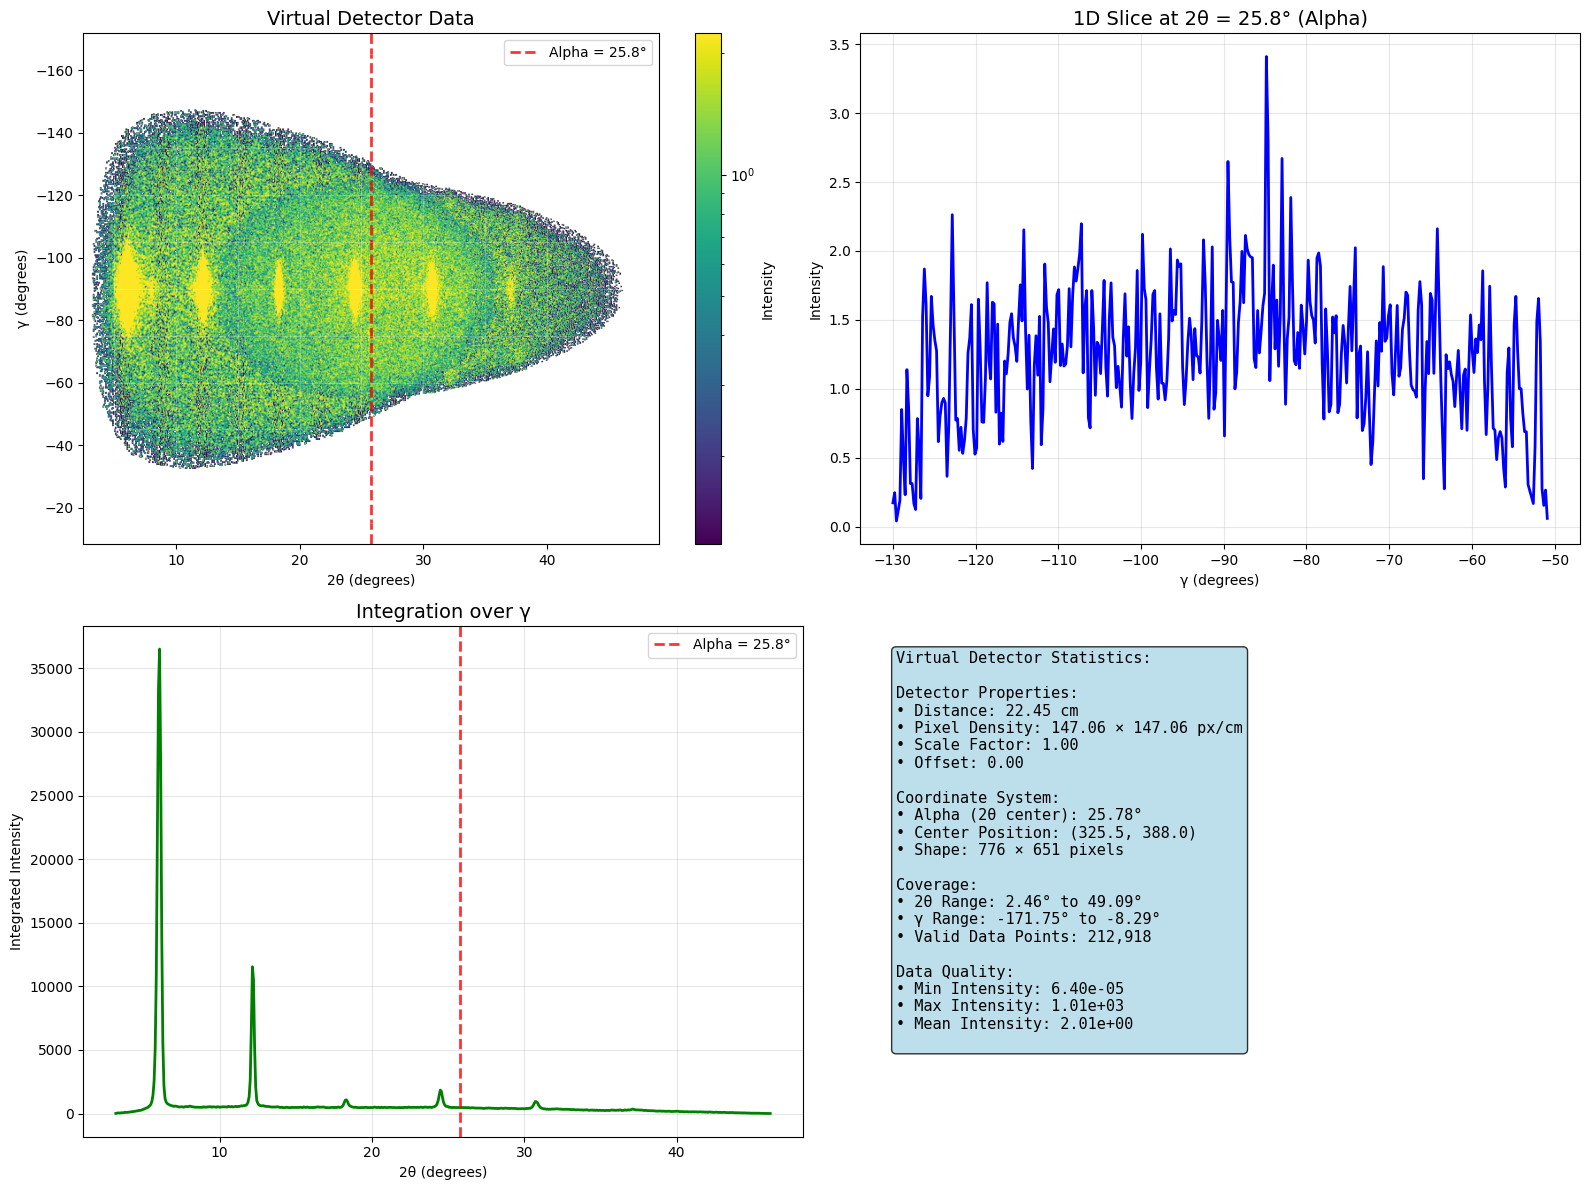

✓ Virtual detector validation completed!


In [15]:
# ============================================================================
# VIRTUAL DETECTOR VALIDATION AND DEMONSTRATION
# ============================================================================
print("=== Virtual Detector Validation ===")

# Compare virtual detector with original detectors
print("Parameter Comparison:")
print("=" * 60)
print(f"{'Parameter':<20} {'Original Det 0':<15} {'Original Det 1':<15} {'Virtual Det':<15}")
print("=" * 60)
print(f"{'Distance (cm)':<20} {area_detectors[0].distance:<15.2f} {area_detectors[1].distance:<15.2f} {virtual_detector.distance:<15.2f}")
print(f"{'Density X':<20} {area_detectors[0].densityXY[0]:<15.2f} {area_detectors[1].densityXY[0]:<15.2f} {virtual_detector.densityXY[0]:<15.2f}")
print(f"{'Density Y':<20} {area_detectors[0].densityXY[1]:<15.2f} {area_detectors[1].densityXY[1]:<15.2f} {virtual_detector.densityXY[1]:<15.2f}")
print(f"{'Scale':<20} {area_detectors[0].scale:<15.2f} {area_detectors[1].scale:<15.2f} {virtual_detector.scale:<15.2f}")
print(f"{'Offset':<20} {area_detectors[0].offset:<15.2f} {area_detectors[1].offset:<15.2f} {virtual_detector.offset:<15.2f}")
print(f"{'Alpha (deg)':<20} {np.rad2deg(area_detectors[0].alpha):<15.2f} {np.rad2deg(area_detectors[1].alpha):<15.2f} {np.rad2deg(virtual_detector.alpha):<15.2f}")

print("\nData Shape Comparison:")
print(f"Original Detector 0: {area_detectors[0].data_converted.shape}")
print(f"Original Detector 1: {area_detectors[1].data_converted.shape}")
print(f"Virtual Detector:    {virtual_detector.detector_shape}")

print("\nCoverage Comparison:")
orig0_points = np.sum(area_detectors[0].data_converted > 0)
orig1_points = np.sum(area_detectors[1].data_converted > 0)
virtual_points = np.sum(virtual_detector.data_converted > 0)

print(f"Original Detector 0: {orig0_points:,} data points")
print(f"Original Detector 1: {orig1_points:,} data points")
print(f"Virtual Detector:    {virtual_points:,} data points")
print(f"Coverage efficiency: {100 * virtual_points / (orig0_points + orig1_points):.1f}%")

# Visualize the virtual detector
print("\n=== Virtual Detector Visualization ===")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Virtual detector data
ax1 = axes[0, 0]
virtual_display = virtual_detector.data_converted.copy()
virtual_display[virtual_display == 0] = np.nan

if np.nansum(virtual_display) > 0:
    valid_data = virtual_display[virtual_display > 0]
    if len(valid_data) > 0:
        vmin = np.percentile(valid_data, 5)
        vmax = np.percentile(valid_data, 95)
        if vmin > 0 and vmax > vmin:
            im1 = ax1.imshow(virtual_display, cmap='viridis',
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                            origin='upper', extent=extent, aspect='auto')
        else:
            im1 = ax1.imshow(virtual_display, cmap='viridis',
                            origin='upper', extent=extent, aspect='auto')
    else:
        im1 = ax1.imshow(virtual_display, cmap='viridis',
                        origin='upper', extent=extent, aspect='auto')

ax1.set_title('Virtual Detector Data', fontsize=14)
ax1.set_xlabel('2θ (degrees)')
ax1.set_ylabel('γ (degrees)')
ax1.axvline(x=np.rad2deg(virtual_detector.alpha), color='red', linestyle='--', 
           linewidth=2, alpha=0.8, label=f'Alpha = {np.rad2deg(virtual_detector.alpha):.1f}°')
ax1.legend()
plt.colorbar(im1, ax=ax1, label='Intensity')

# Add grid lines
for twoth in range(int(common_twoth.min()//5)*5, int(common_twoth.max()//5)*5+5, 5):
    if common_twoth.min() <= twoth <= common_twoth.max():
        ax1.axvline(x=twoth, color='white', alpha=0.3, linewidth=0.5)

for gamma in range(int(common_gamma.min()//15)*15, int(common_gamma.max()//15)*15+15, 15):
    if common_gamma.min() <= gamma <= common_gamma.max():
        ax1.axhline(y=gamma, color='white', alpha=0.3, linewidth=0.5)

# 1D slice at alpha (center 2θ)
ax2 = axes[0, 1]
alpha_twoth = np.rad2deg(virtual_detector.alpha)
closest_idx = np.argmin(np.abs(common_twoth - alpha_twoth))
alpha_slice = virtual_detector.data_converted[:, closest_idx]
valid_alpha = alpha_slice > 0

ax2.plot(common_gamma[valid_alpha], alpha_slice[valid_alpha], 'b-', linewidth=2)
ax2.set_xlabel('γ (degrees)')
ax2.set_ylabel('Intensity')
ax2.set_title(f'1D Slice at 2θ = {alpha_twoth:.1f}° (Alpha)', fontsize=14)
ax2.grid(True, alpha=0.3)

# Integration over γ
ax3 = axes[1, 0]
integrated_gamma = np.nansum(virtual_detector.data_converted, axis=0)
valid_integration = integrated_gamma > 0

ax3.plot(common_twoth[valid_integration], integrated_gamma[valid_integration], 'g-', linewidth=2)
ax3.set_xlabel('2θ (degrees)')
ax3.set_ylabel('Integrated Intensity')
ax3.set_title('Integration over γ', fontsize=14)
ax3.axvline(x=alpha_twoth, color='red', linestyle='--', linewidth=2, alpha=0.8, 
           label=f'Alpha = {alpha_twoth:.1f}°')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Virtual detector statistics
ax4 = axes[1, 1]
ax4.axis('off')

stats_text = f"""Virtual Detector Statistics:

Detector Properties:
• Distance: {virtual_detector.distance:.2f} cm
• Pixel Density: {virtual_detector.densityXY[0]:.2f} × {virtual_detector.densityXY[1]:.2f} px/cm
• Scale Factor: {virtual_detector.scale:.2f}
• Offset: {virtual_detector.offset:.2f}

Coordinate System:
• Alpha (2θ center): {np.rad2deg(virtual_detector.alpha):.2f}°
• Center Position: ({virtual_detector.centerXY[0]:.1f}, {virtual_detector.centerXY[1]:.1f})
• Shape: {virtual_detector.detector_shape[0]} × {virtual_detector.detector_shape[1]} pixels

Coverage:
• 2θ Range: {virtual_detector.twoth_range[0]:.2f}° to {virtual_detector.twoth_range[1]:.2f}°
• γ Range: {virtual_detector.gamma_range[0]:.2f}° to {virtual_detector.gamma_range[1]:.2f}°
• Valid Data Points: {virtual_points:,}

Data Quality:
• Min Intensity: {np.nanmin(virtual_detector.data_converted[virtual_detector.data_converted > 0]):.2e}
• Max Intensity: {np.nanmax(virtual_detector.data_converted):.2e}
• Mean Intensity: {np.nanmean(virtual_detector.data_converted[virtual_detector.data_converted > 0]):.2e}
"""

ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

print("✓ Virtual detector validation completed!")